In [6]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Ignoring future warnings in Python
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [12]:
df = load("data/train.csv")
X,y = preprocess(df)

Loading data ...
Encoding variables ...


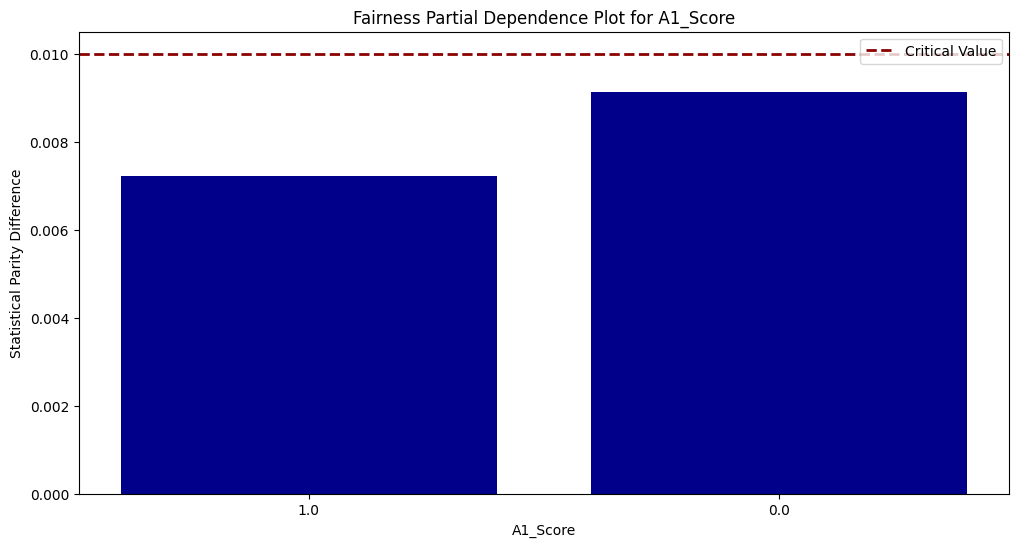

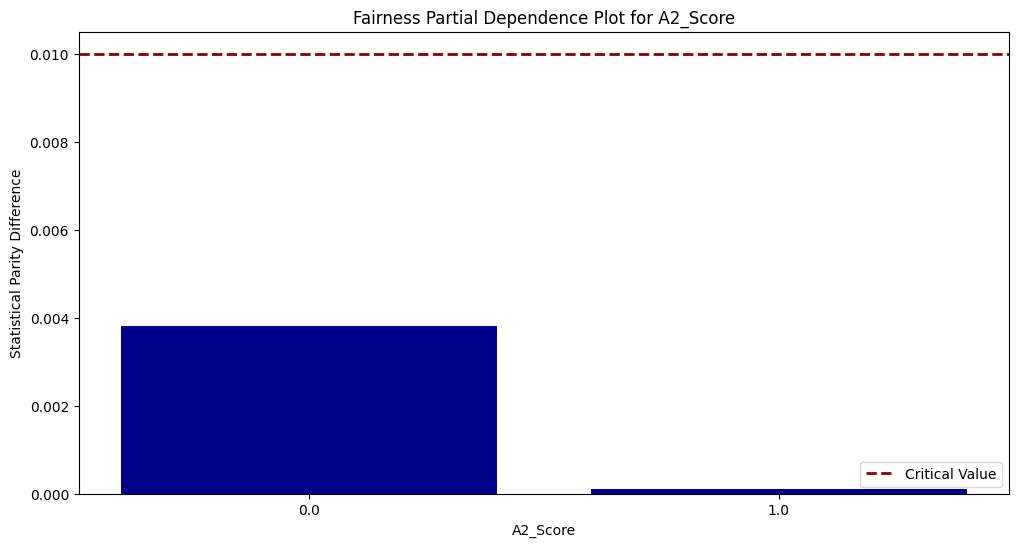

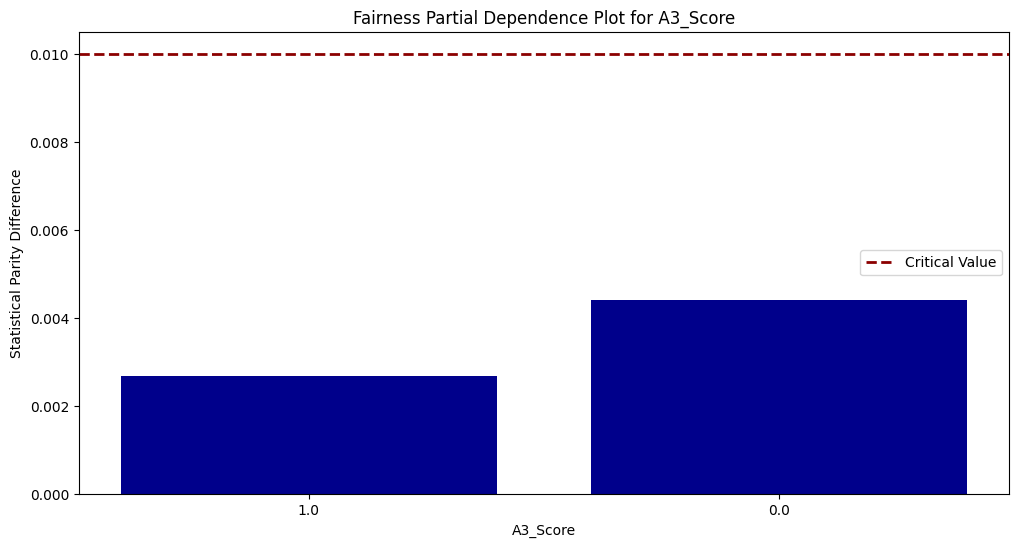

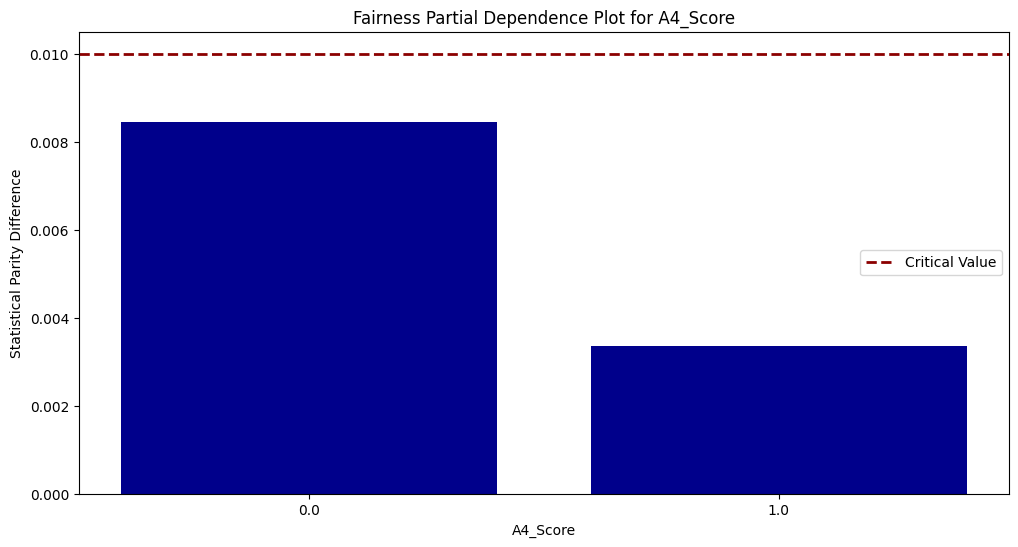

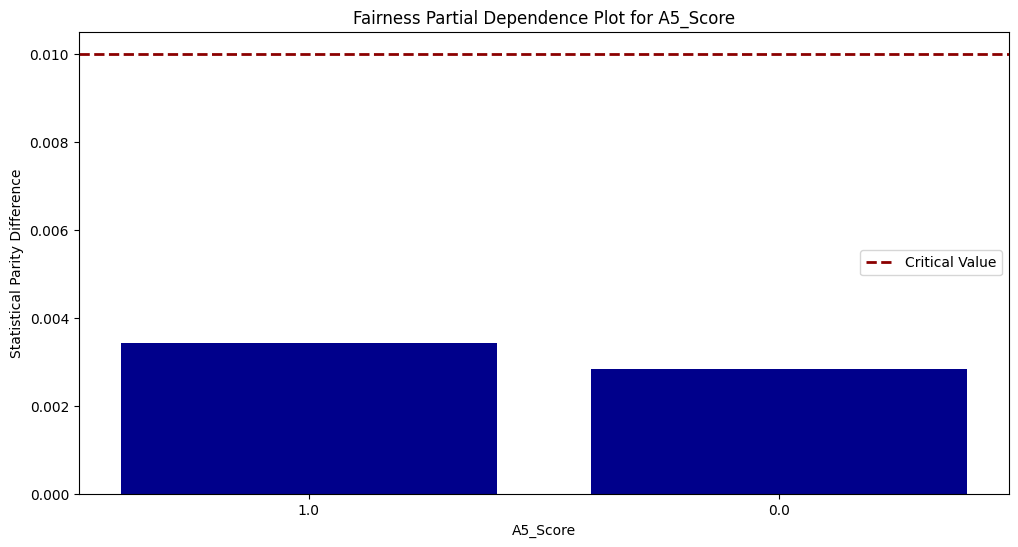

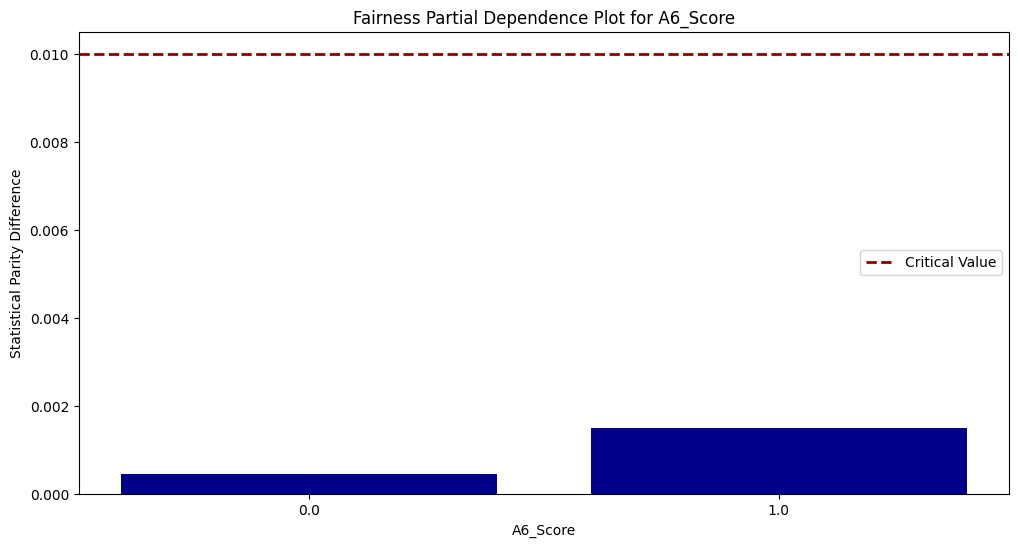

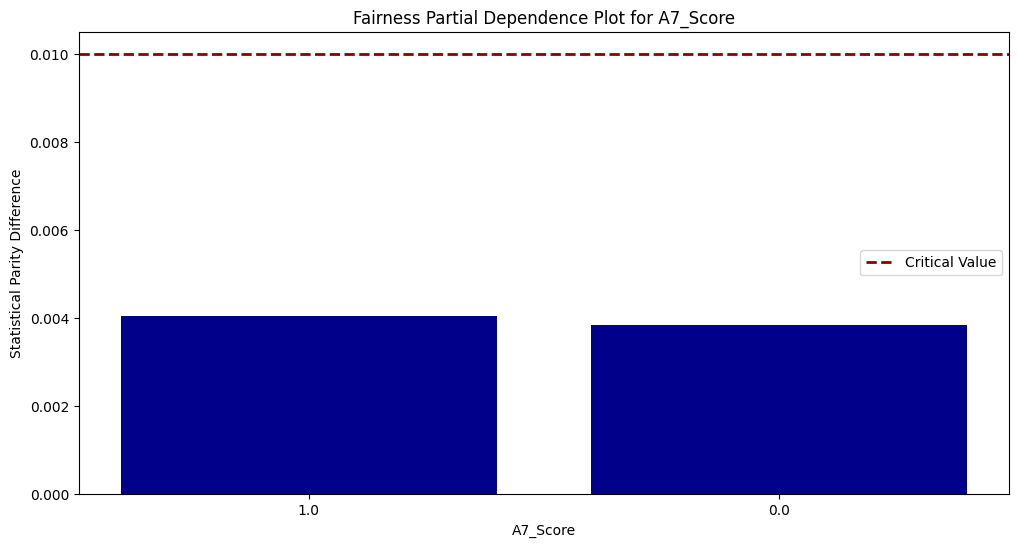

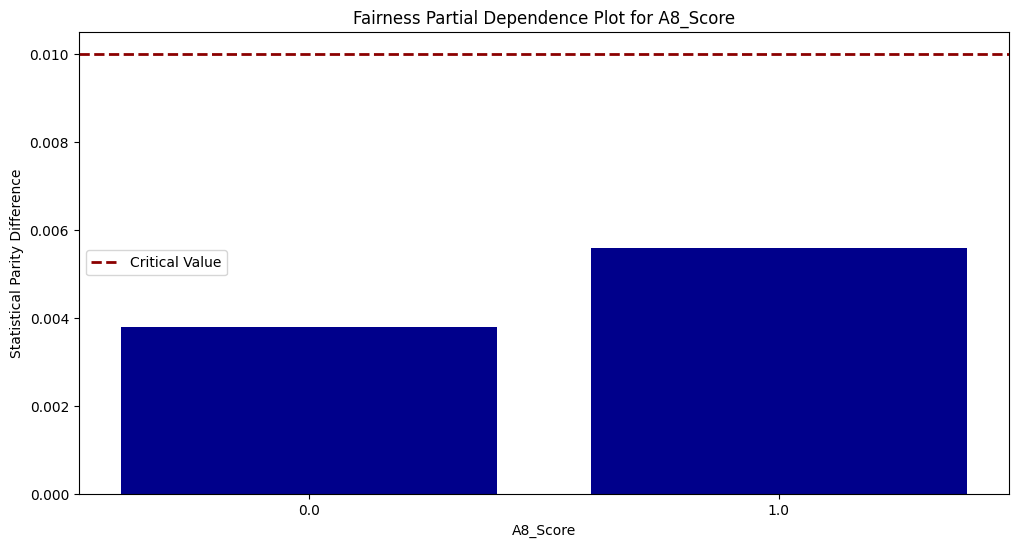

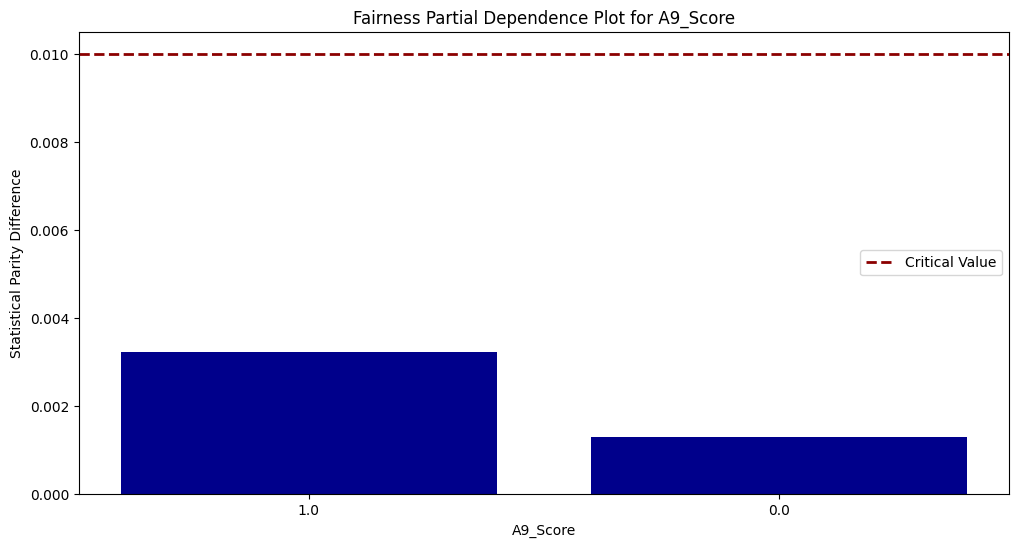

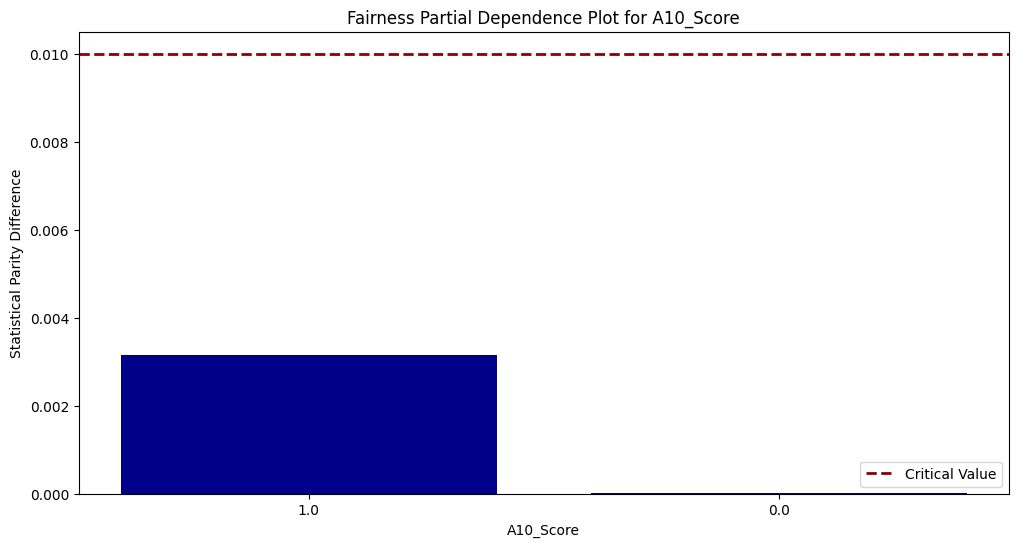

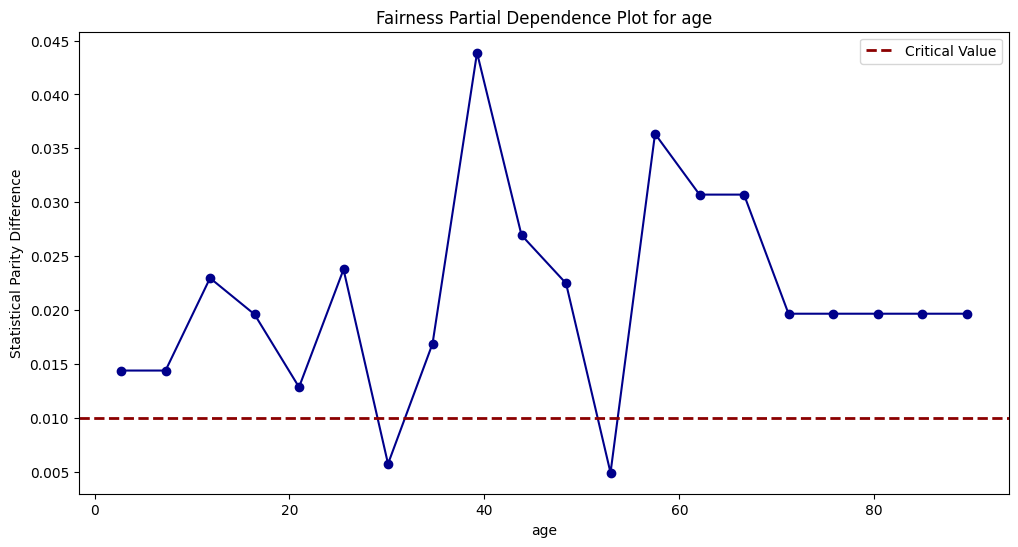

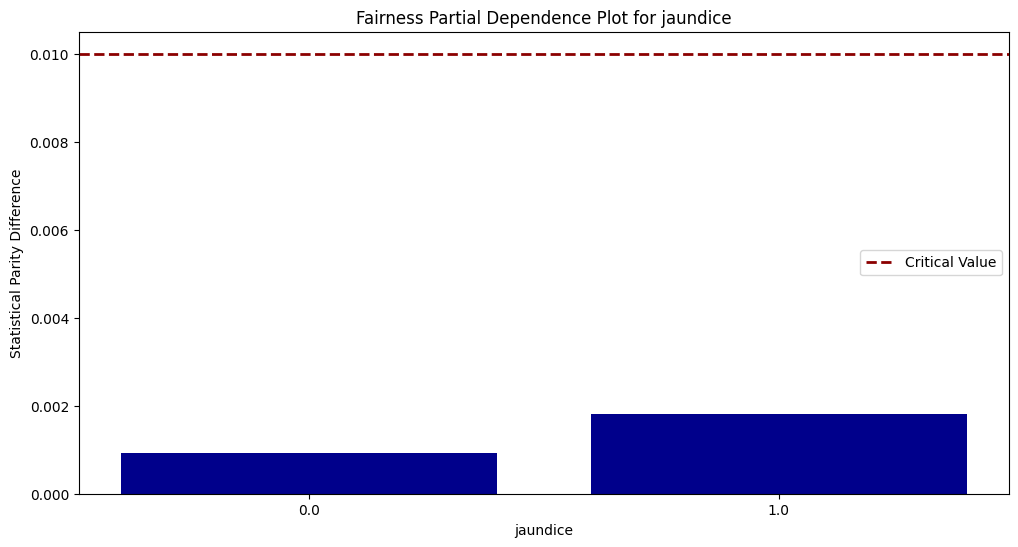

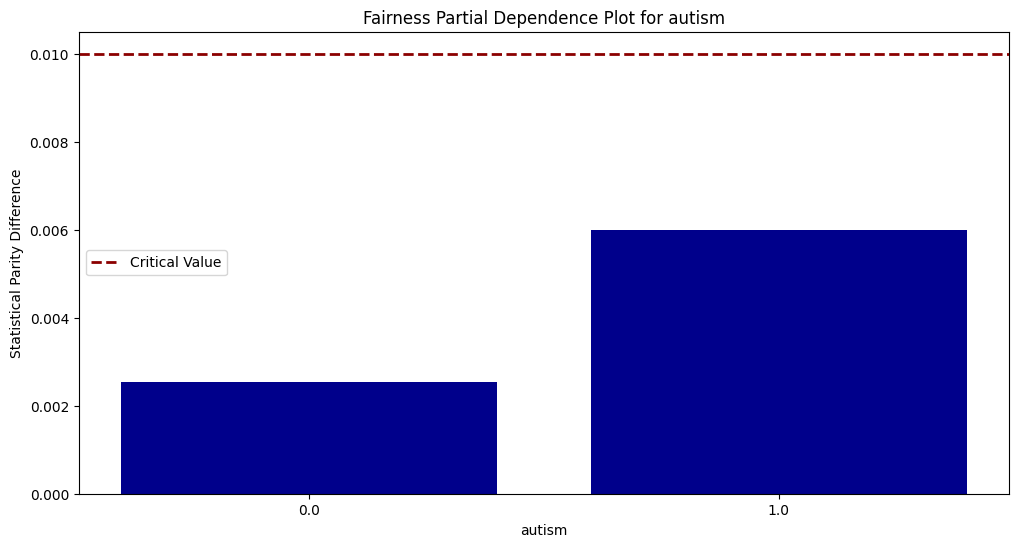

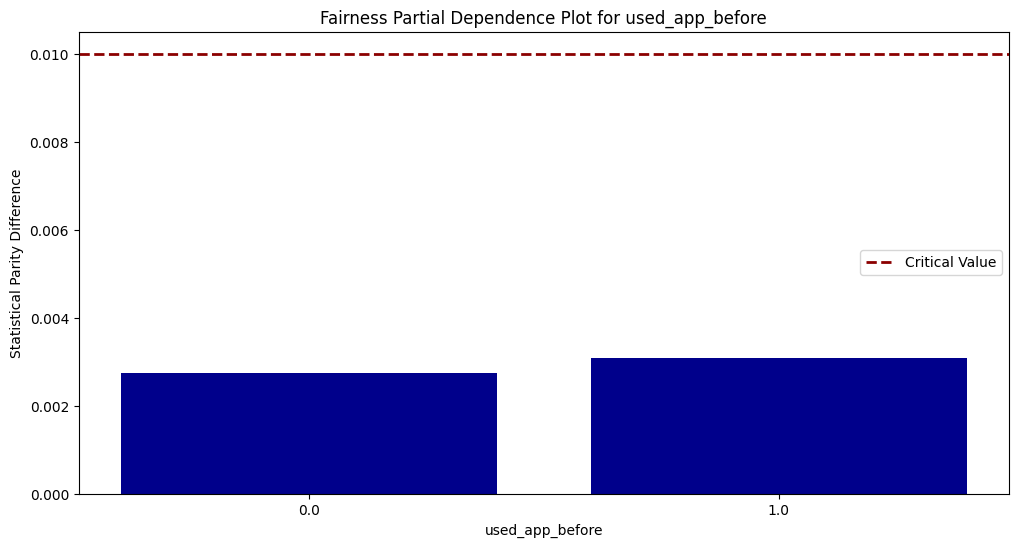

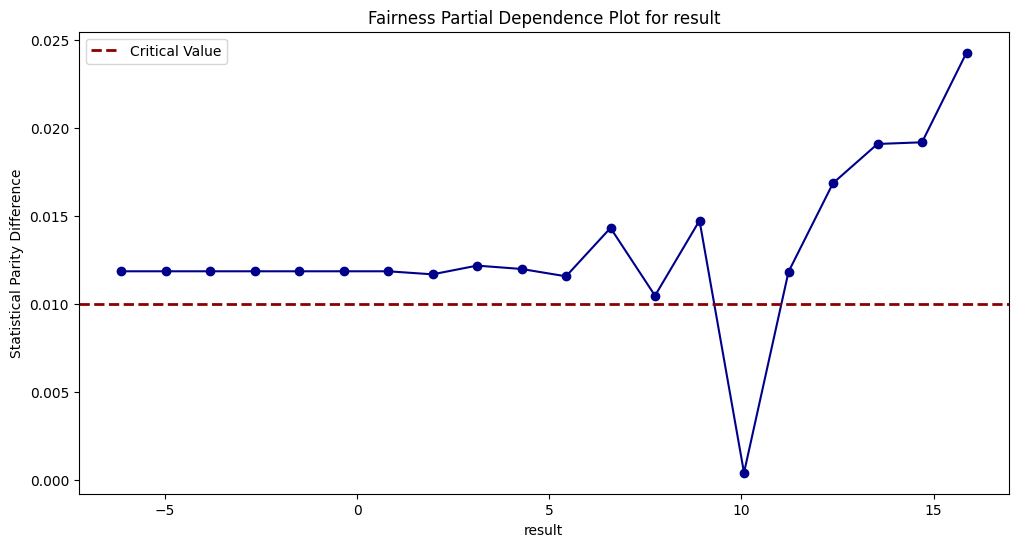

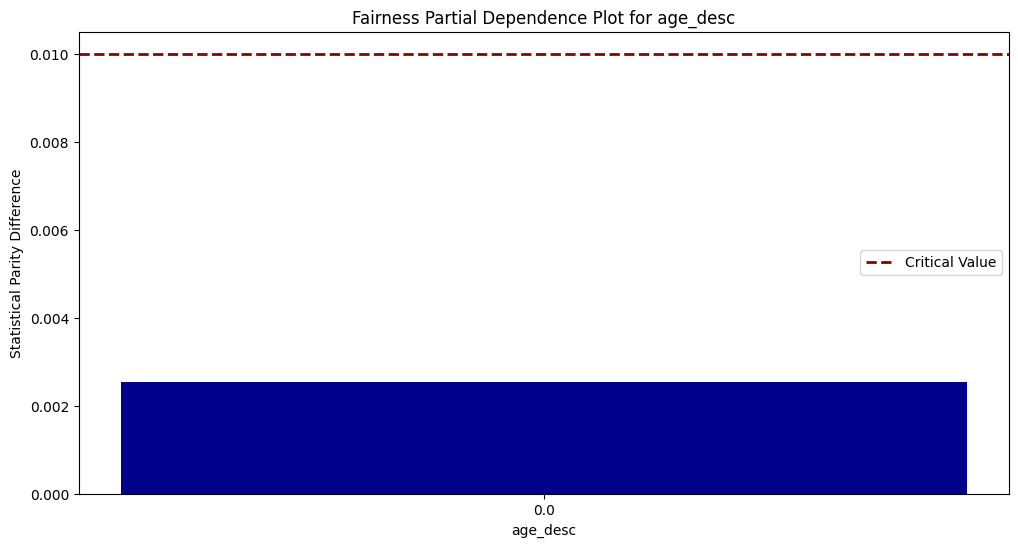

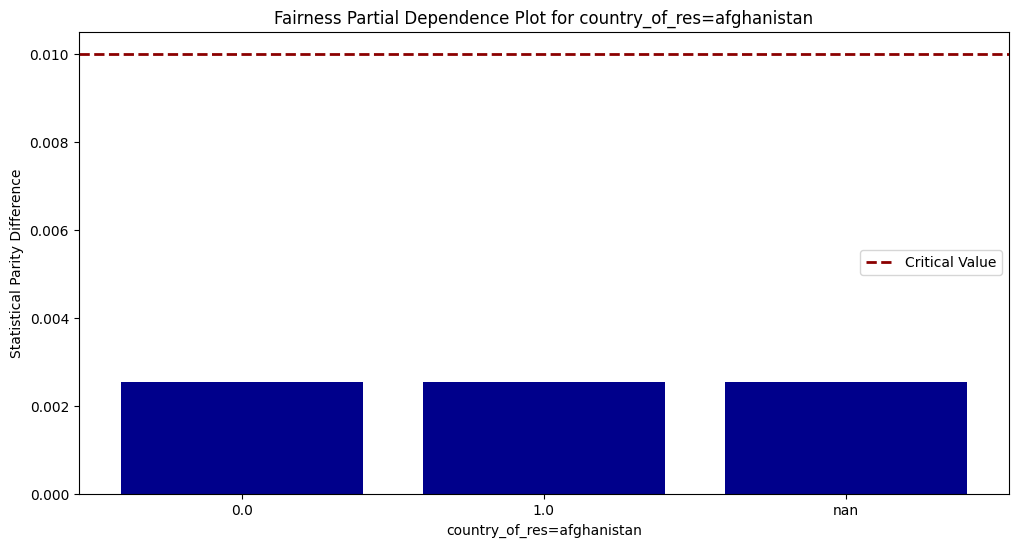

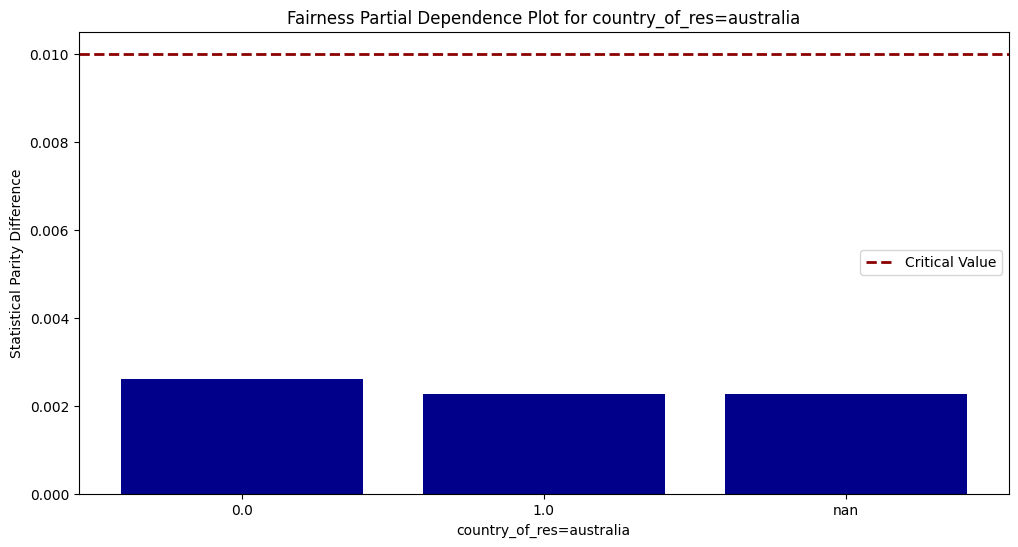

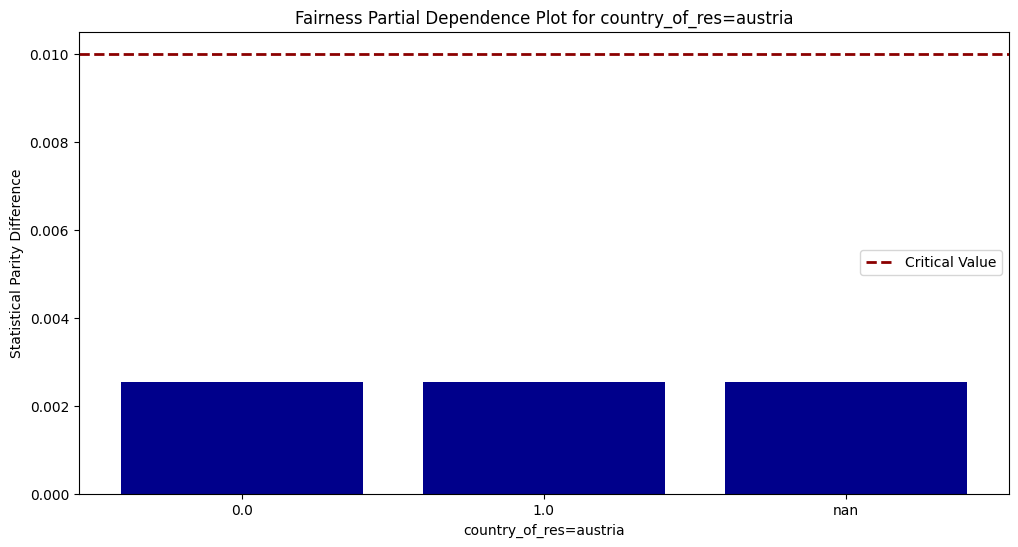

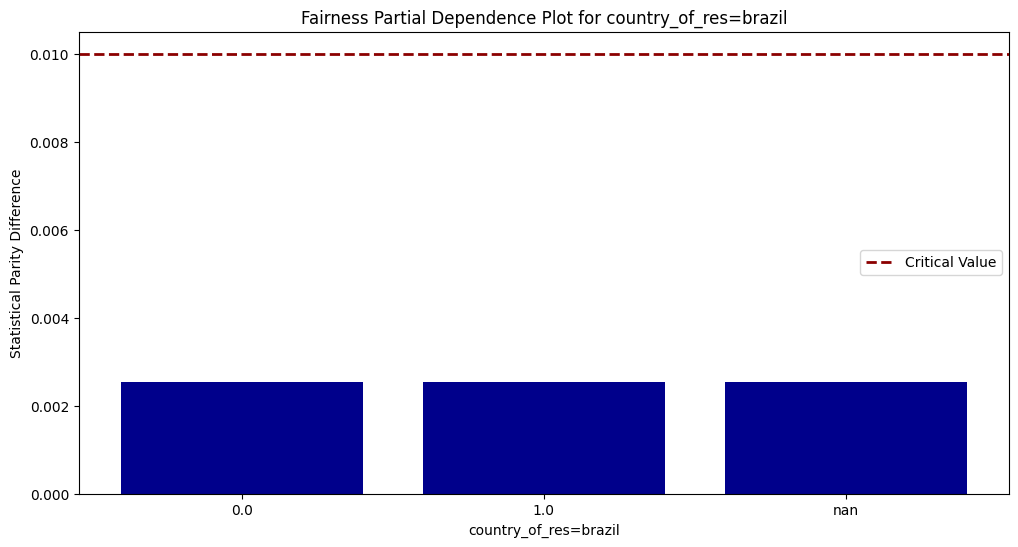

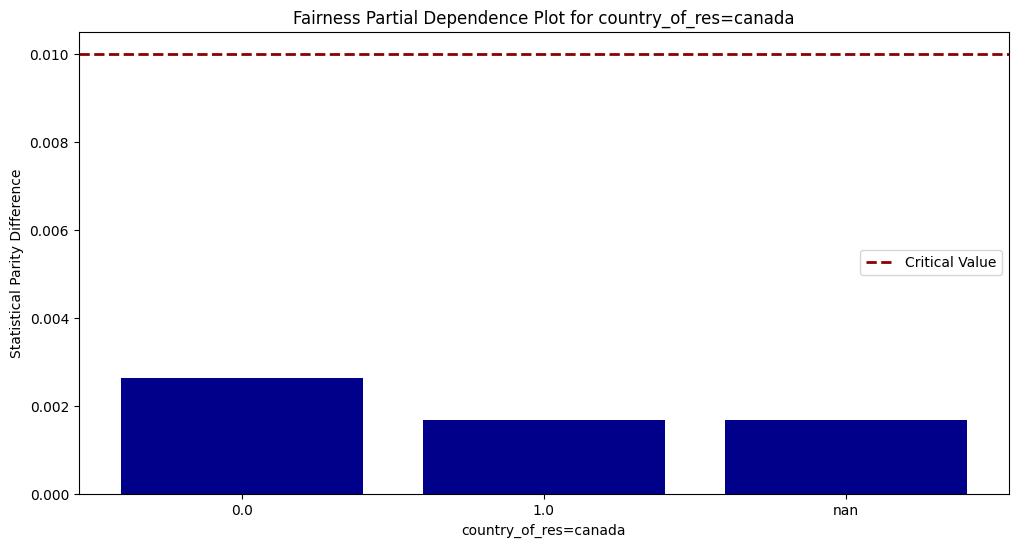

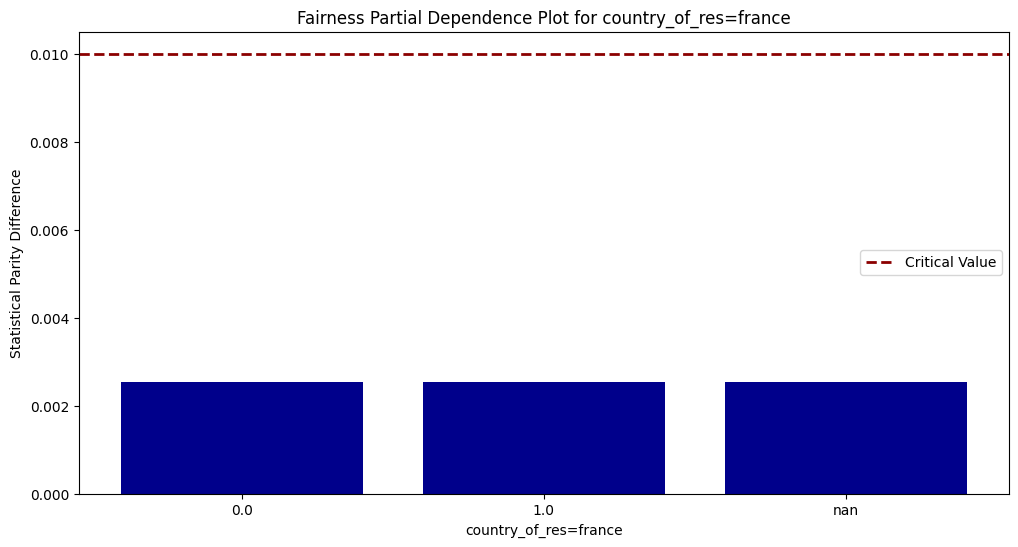

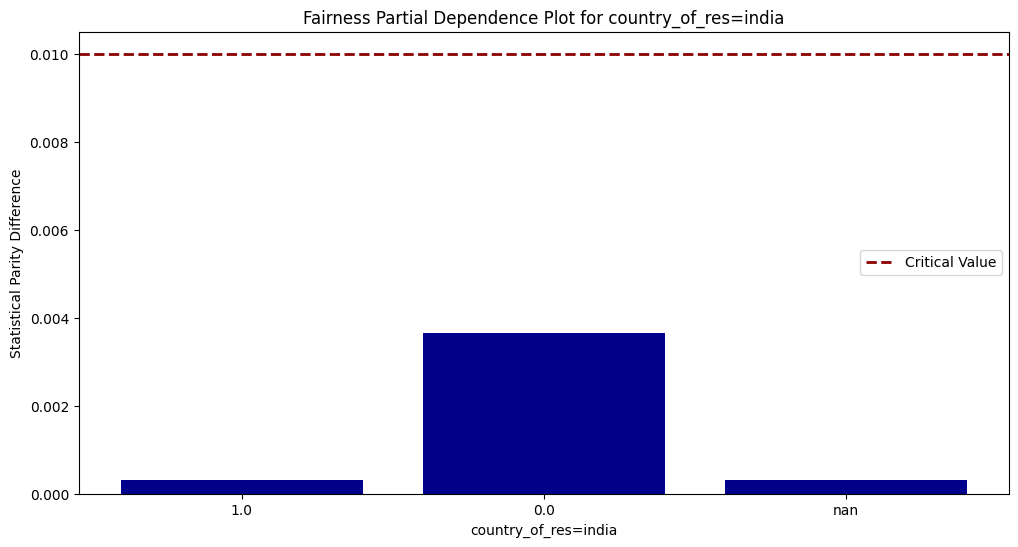

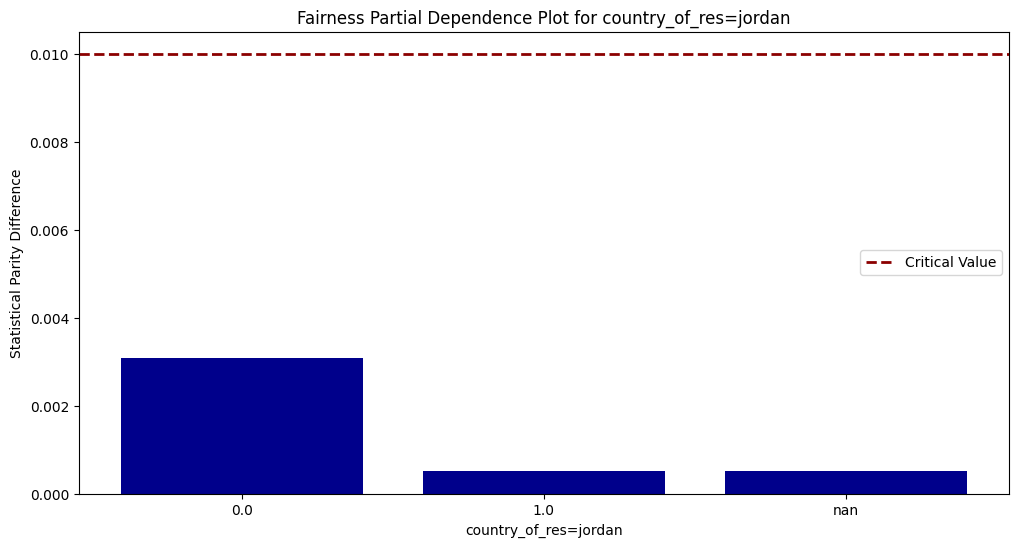

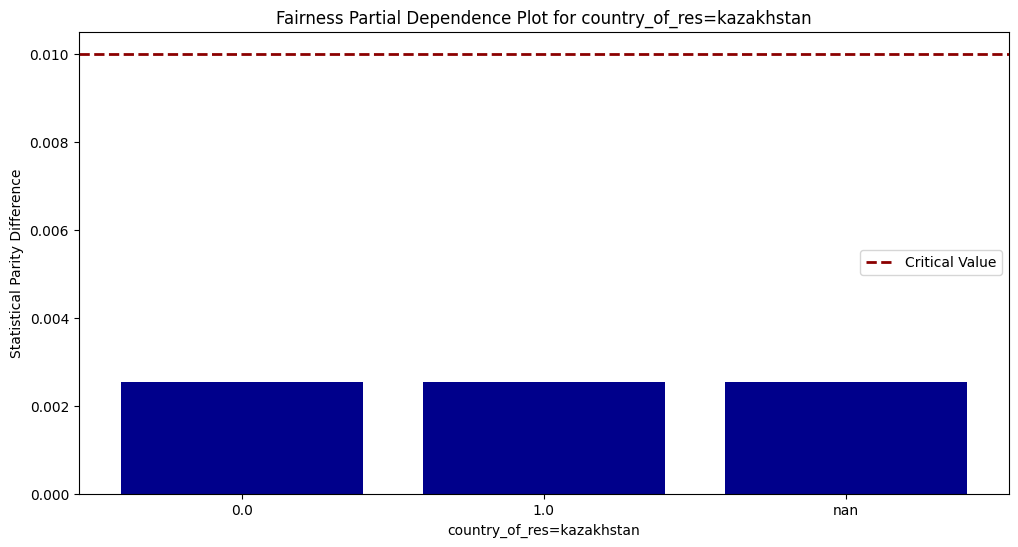

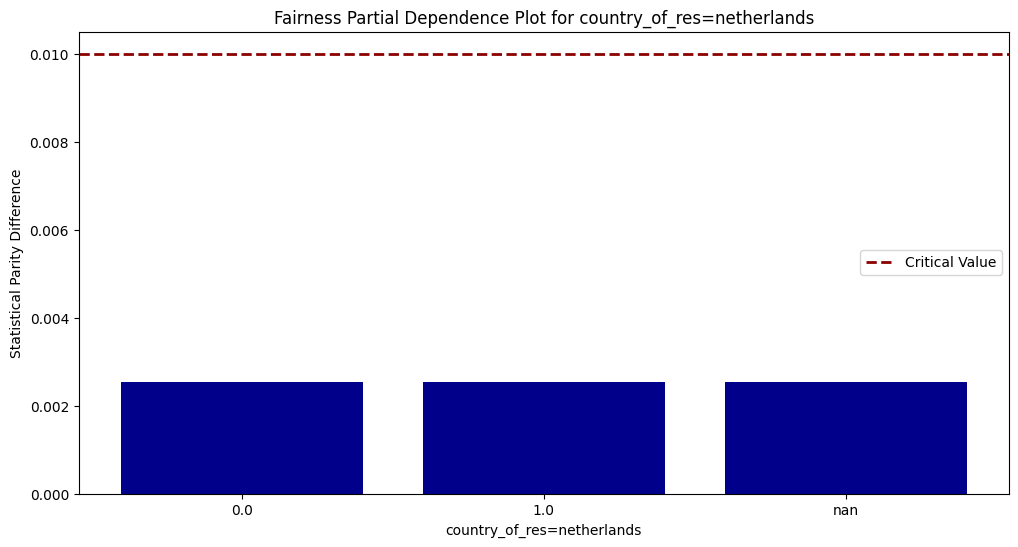

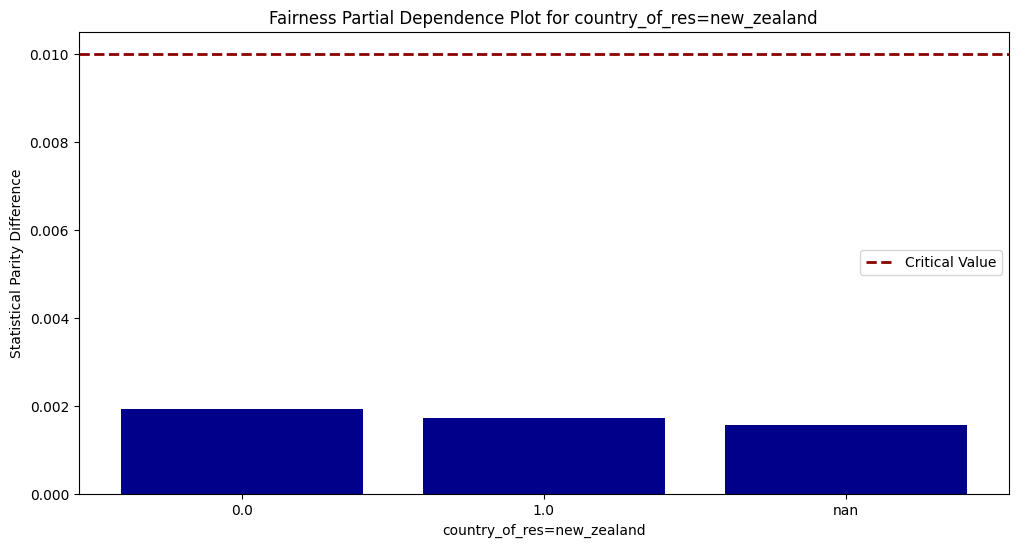

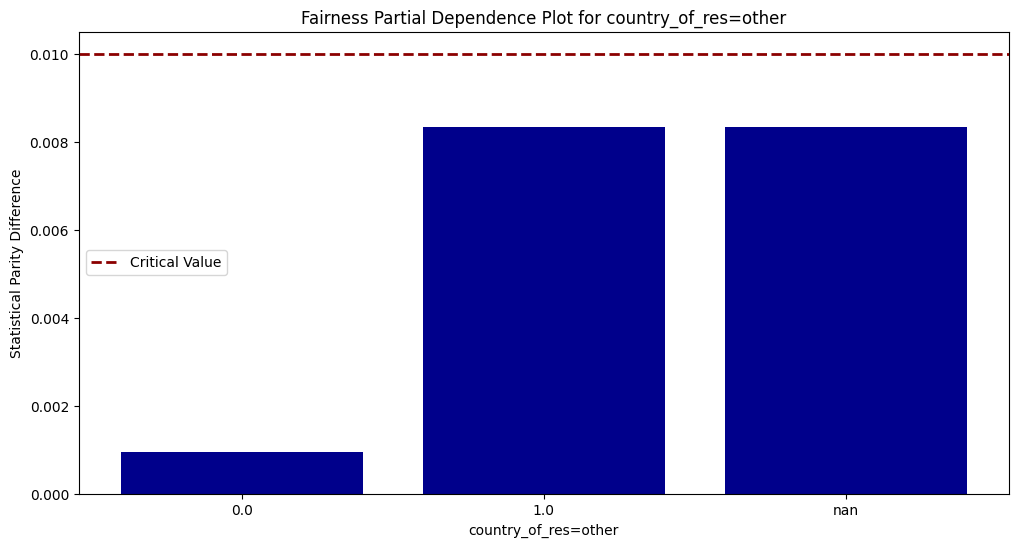

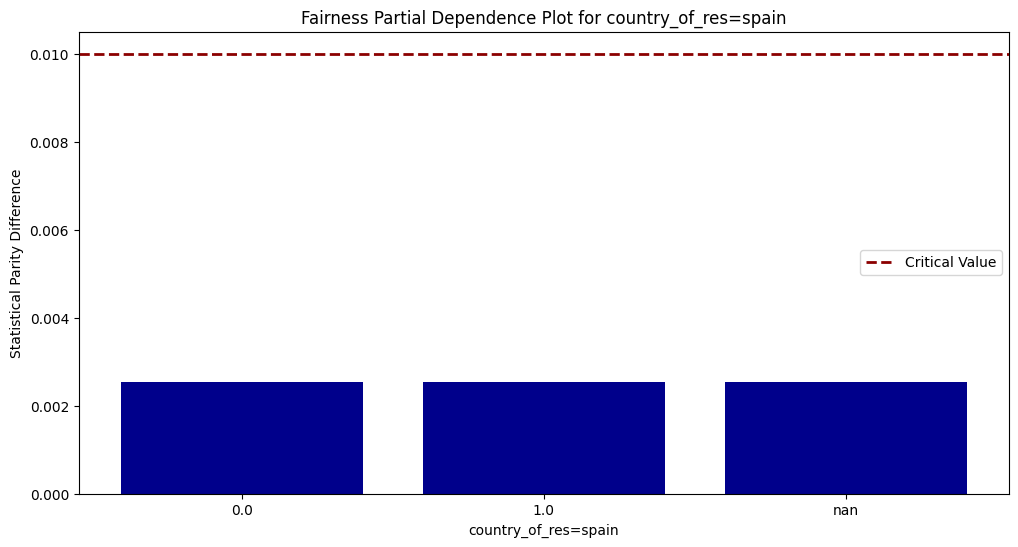

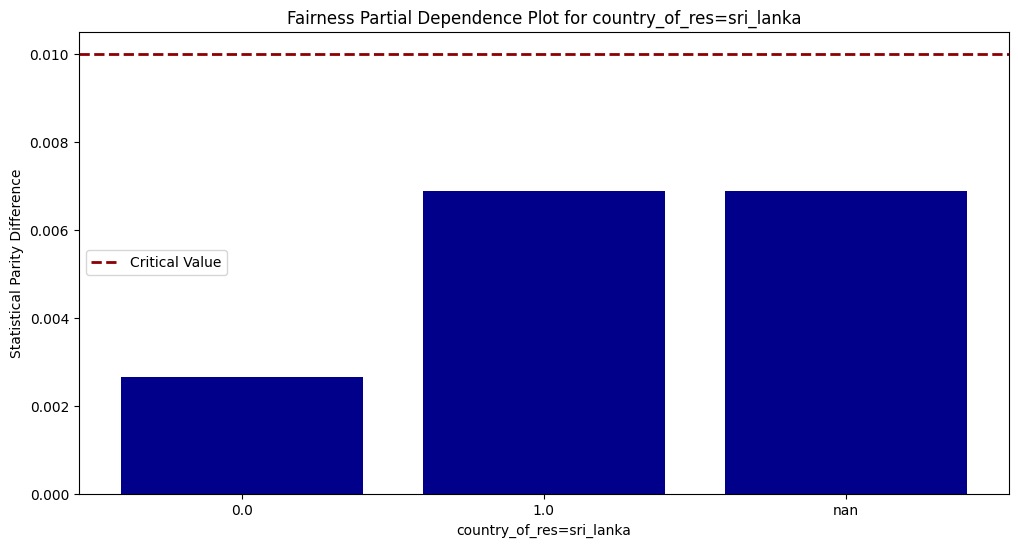

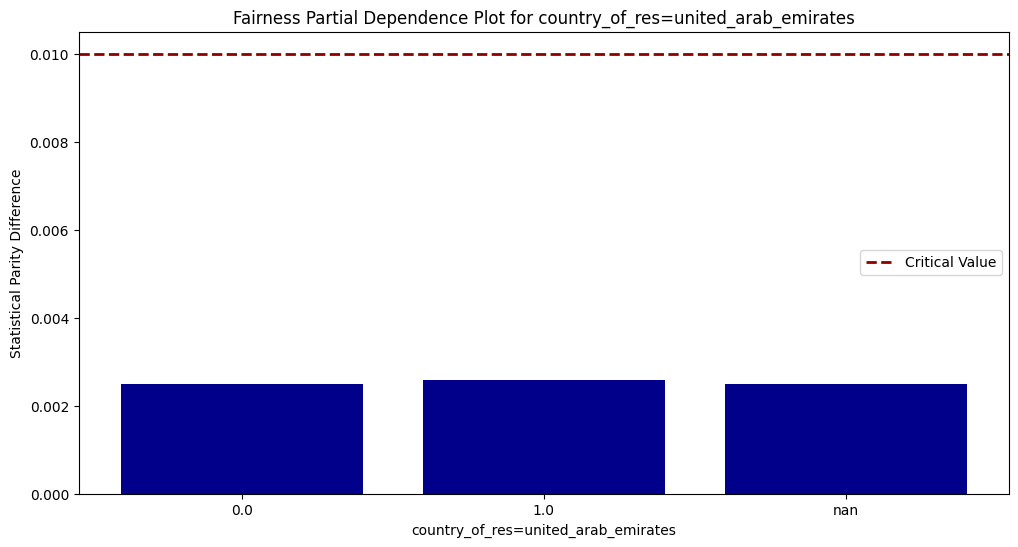

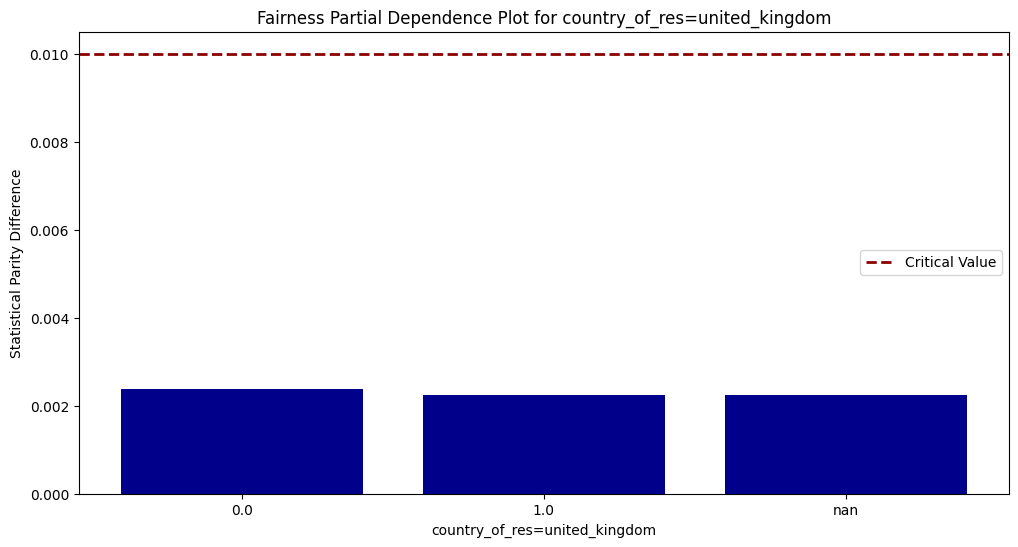

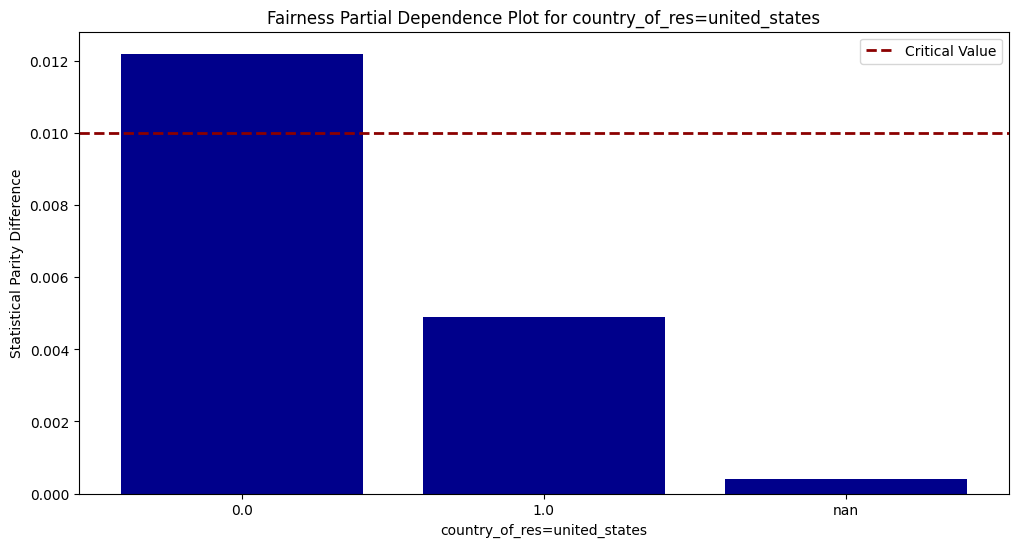

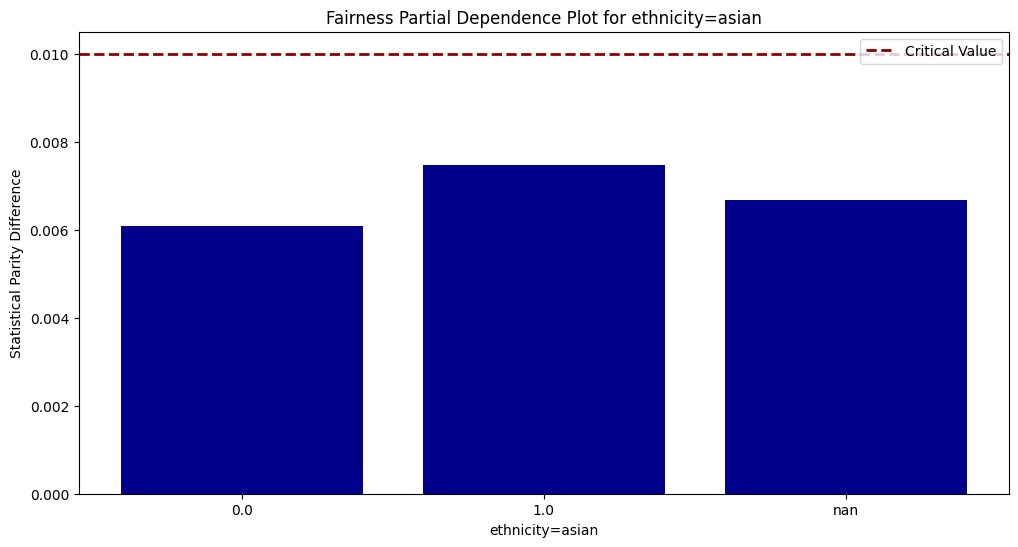

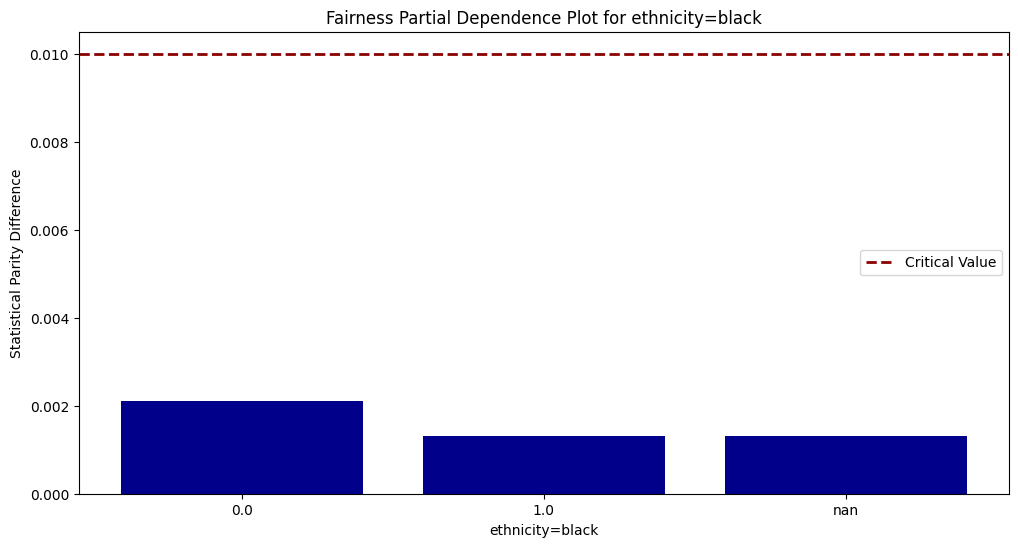

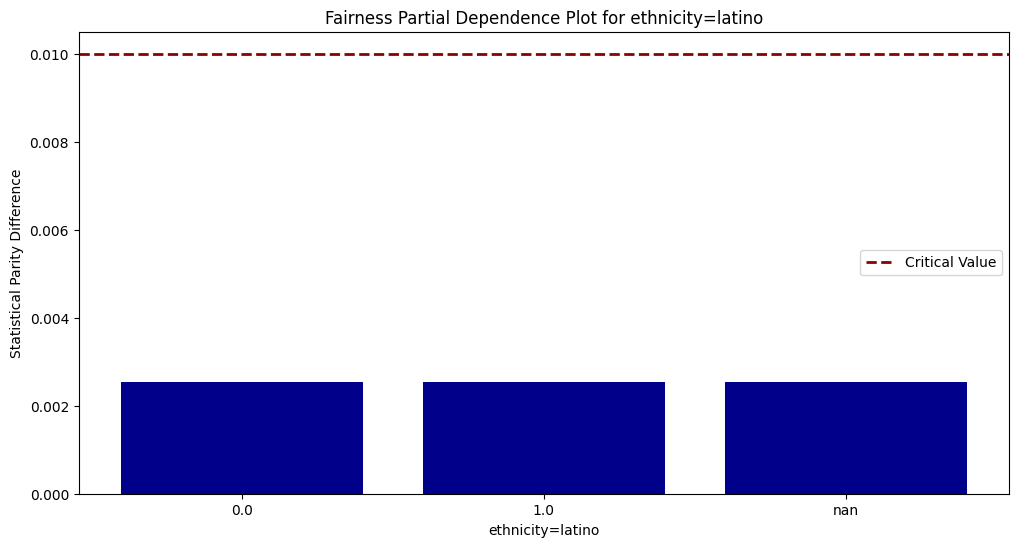

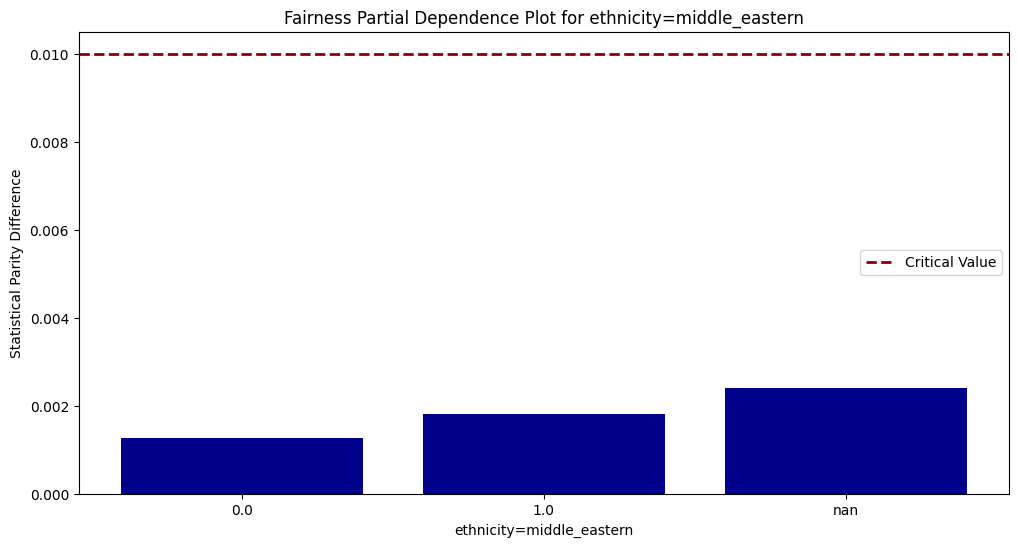

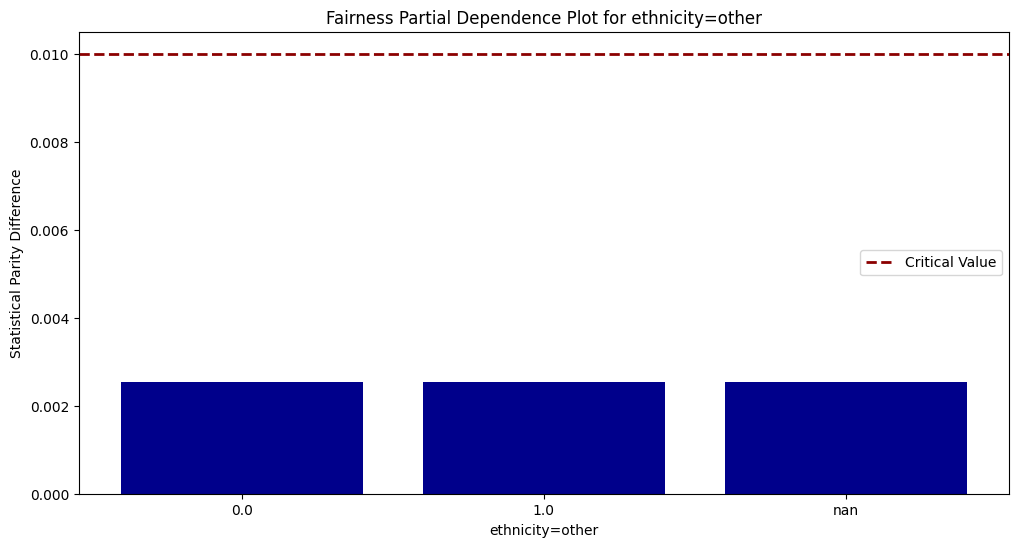

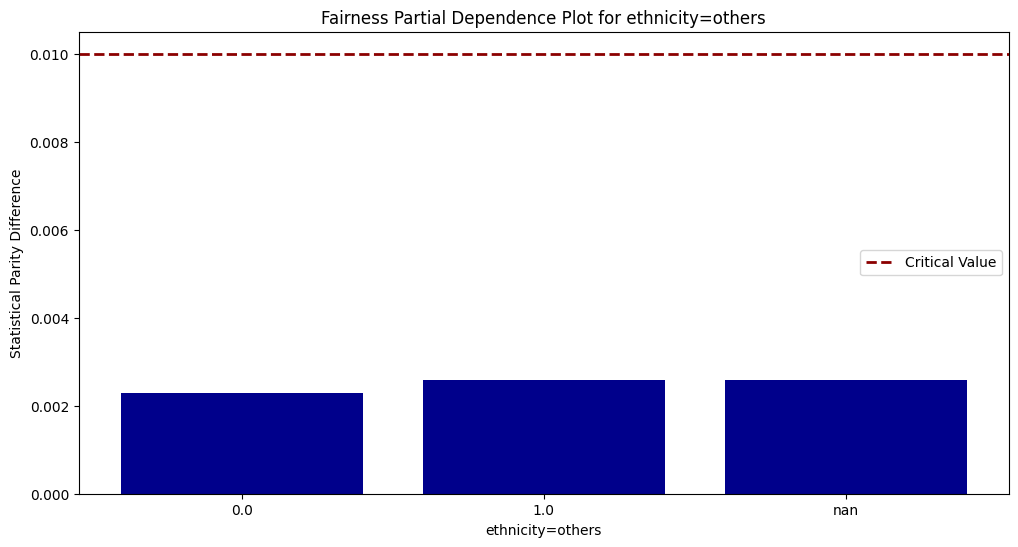

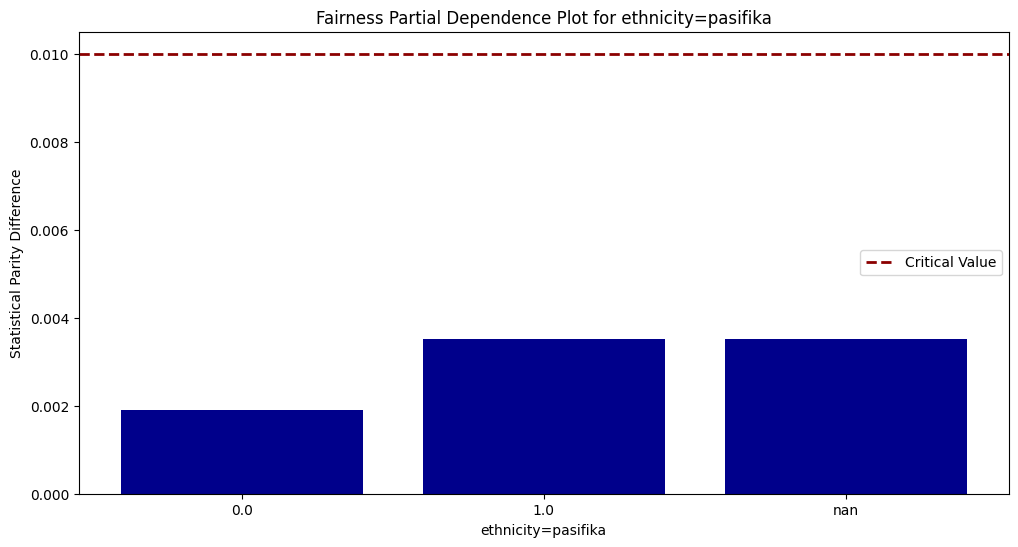

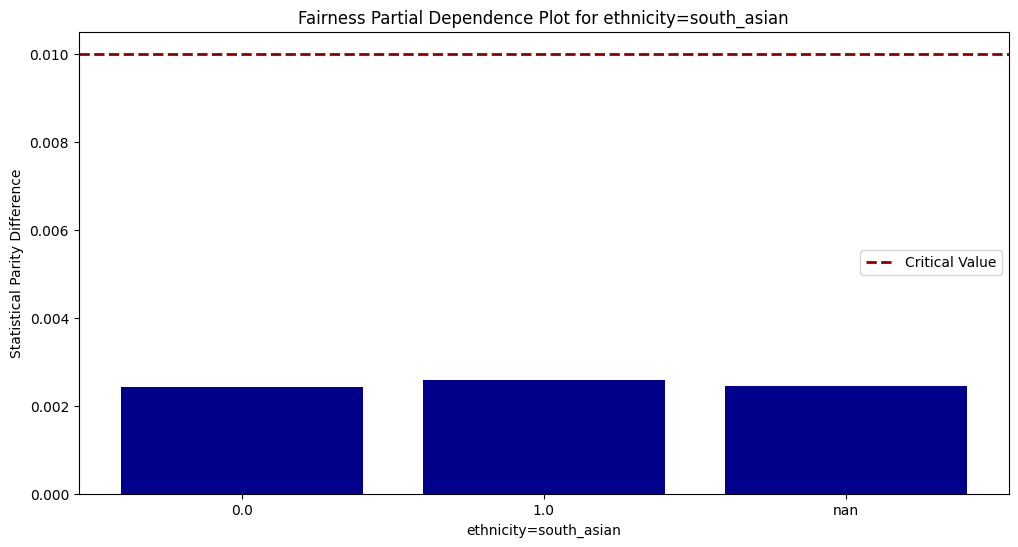

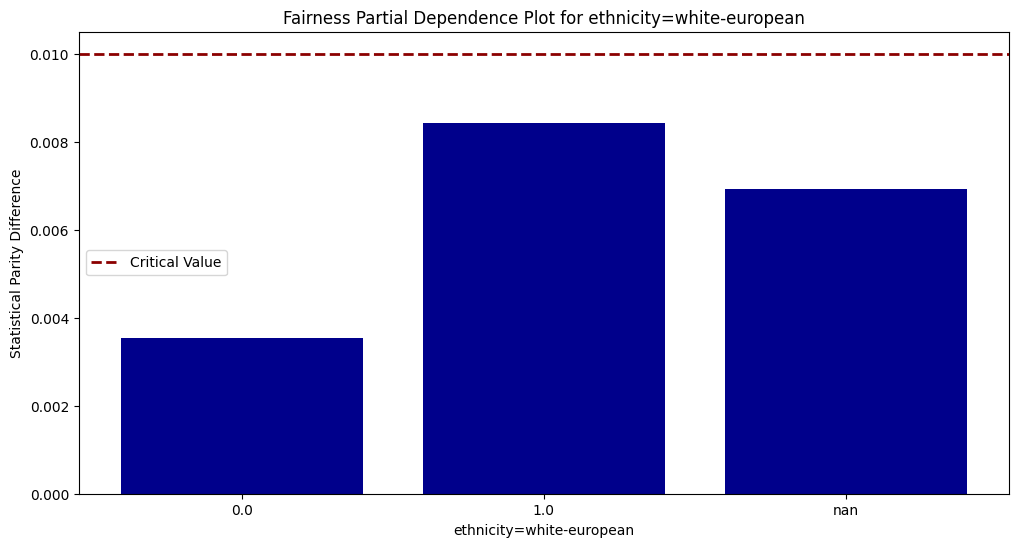

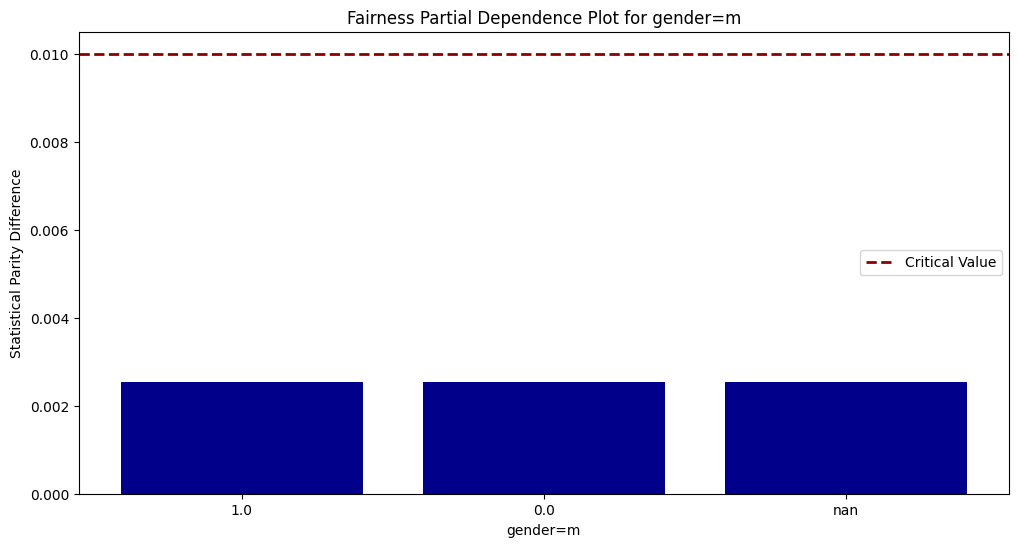

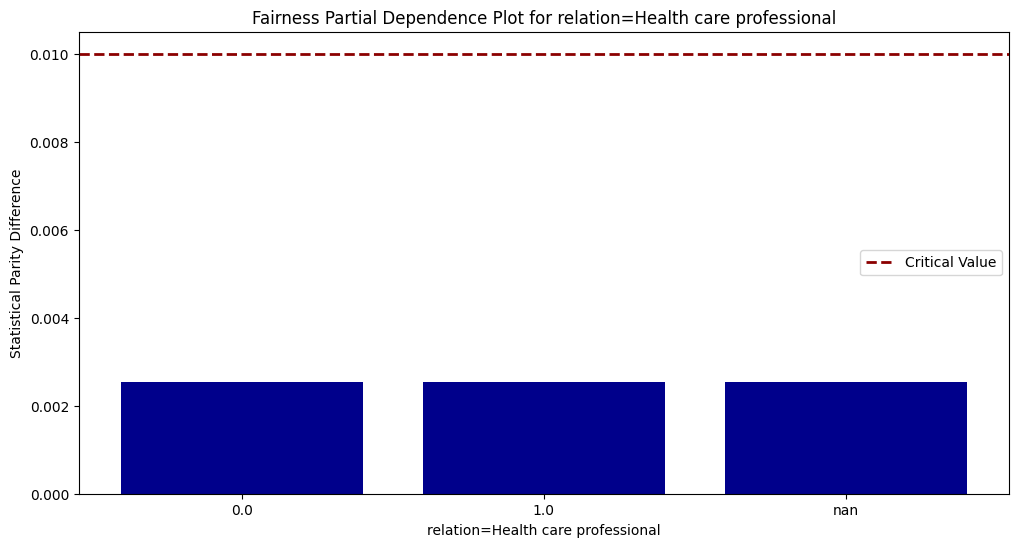

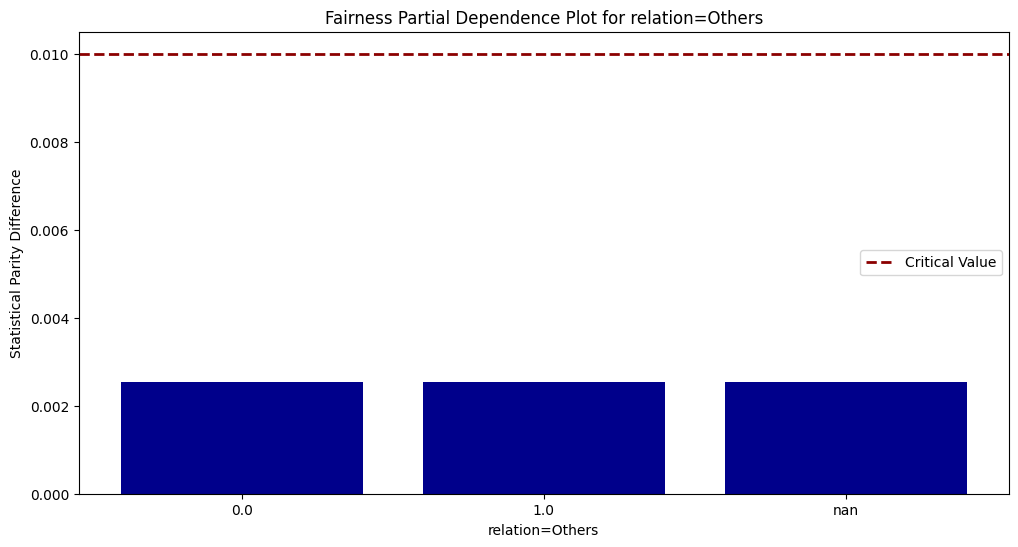

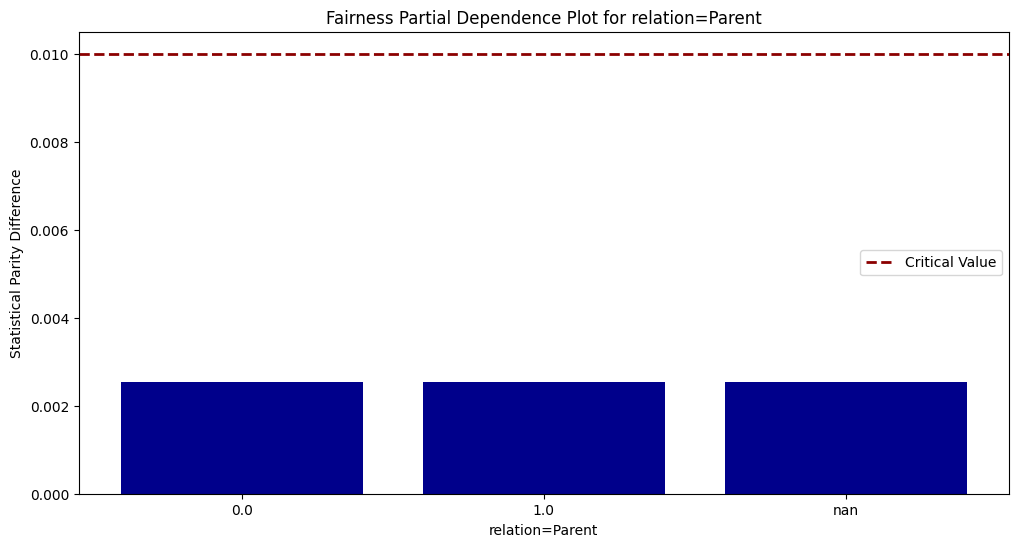

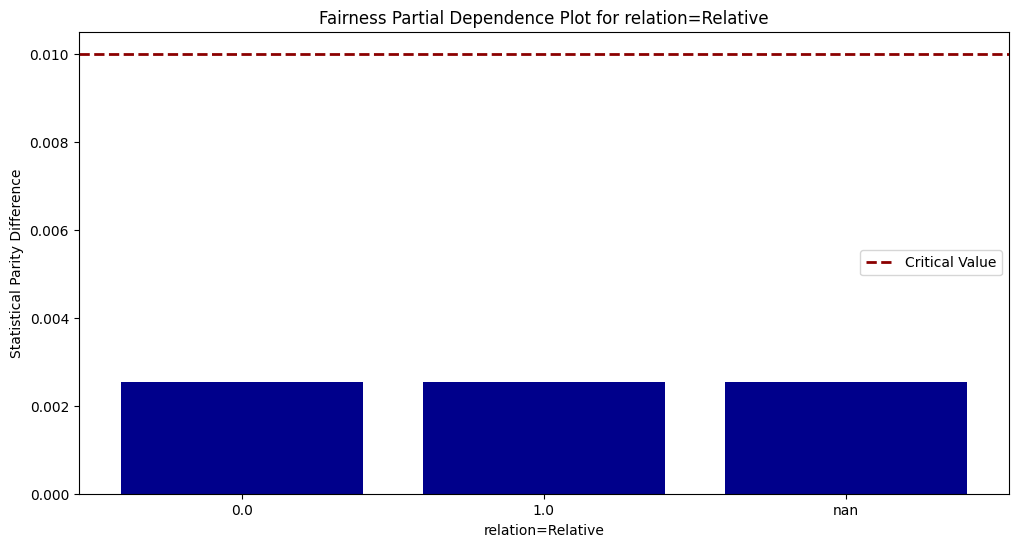

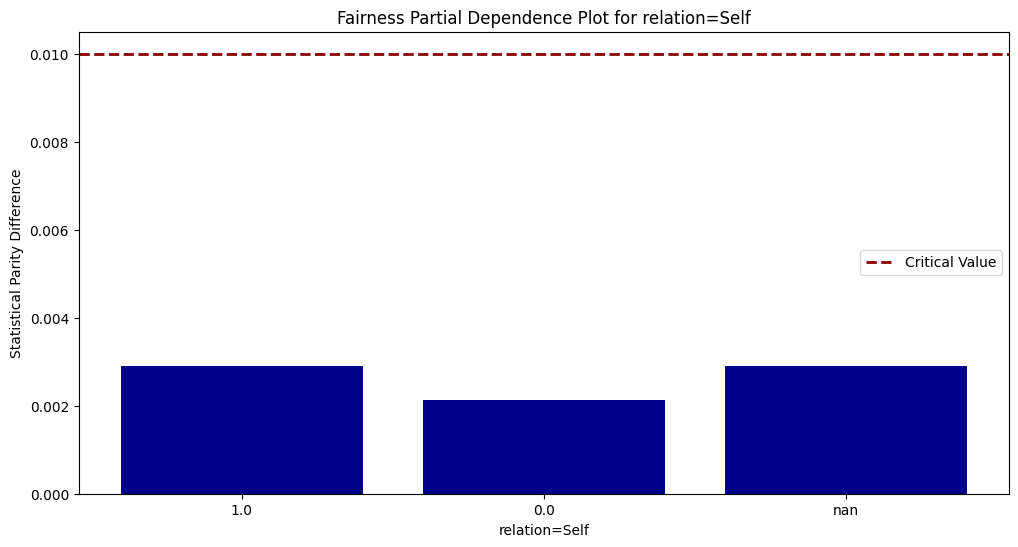

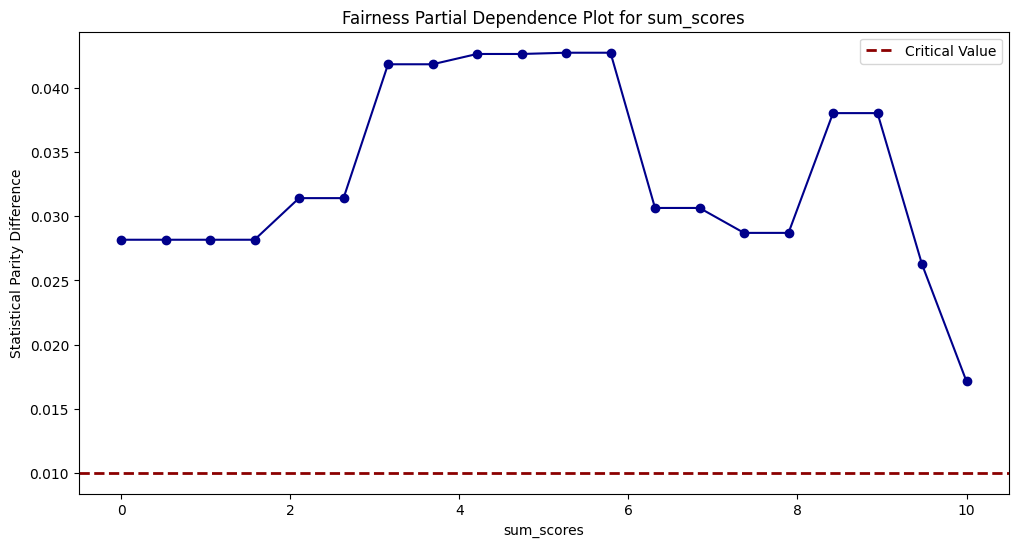

In [33]:
# Load the XGBoost model
with open(model_path, 'rb') as file:
    xgb_model = pickle.load(file)

# Statistical Parity Function
def statistical_parity(model, X, sensitive_feature, sensitive_feature_value, feature_to_test, feature_value):
    X_temp = X.copy()
    X_temp[feature_to_test] = feature_value
    predictions = model.predict_proba(X_temp)[:, 1]  
    
    # Calculate probabilities for the protected group
    protected_group_prob = predictions[X_temp[sensitive_feature] == sensitive_feature_value].mean()
    # Calculate probabilities for the unprotected group
    unprotected_group_prob = predictions[X_temp[sensitive_feature] != sensitive_feature_value].mean()

    # Statistical parity is the absolute difference in probabilities
    return abs(protected_group_prob - unprotected_group_prob)

# Plot FPDP for each feature
def plot_fpdp_for_all_features(model, X, sensitive_feature, protected_value, critical_value):
    for feature in X.columns:
        if feature == sensitive_feature or feature.endswith(sensitive_feature):  # Skip the protected feature itself
            continue

        is_categorical = True if 'Score' in feature or X[feature].nunique() < 10 else False  # Detect if the feature is categorical

        values = []
        parity_differences = []

        if is_categorical:
            categories = X[feature].unique()
            for category in categories:
                parity_diff = statistical_parity(model, X, sensitive_feature, protected_value, feature, category)
                values.append(category)
                parity_differences.append(parity_diff)
            
            plt.figure(figsize=(12, 6))
            plt.bar([str(v) for v in values], parity_differences, color='darkblue')
        
        else:
            # Continuous feature, vary over a range
            min_value, max_value = X[feature].min(), X[feature].max()
            values = np.linspace(min_value, max_value, num=20)
            for value in values:
                parity_diff = statistical_parity(model, X, sensitive_feature, protected_value, feature, value)
                parity_differences.append(parity_diff)
            
            plt.figure(figsize=(12, 6))
            plt.plot(values, parity_differences, marker='o', linestyle='-', color='darkblue')

        plt.axhline(y=critical_value, color='darkred', linestyle='--', label='Critical Value', linewidth = 2)
        plt.xlabel(feature)
        plt.ylabel('Statistical Parity Difference')
        plt.title(f'Fairness Partial Dependence Plot for {feature}')
        plt.legend()
        plt.show()

plot_fpdp_for_all_features(xgb_model, X, 'gender=f', protected_value=0, critical_value=0.01)


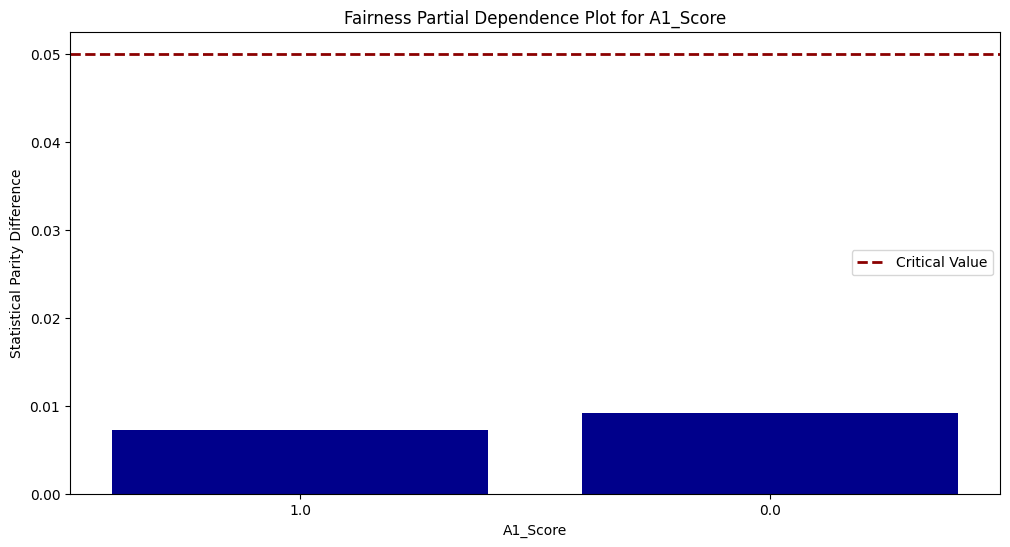

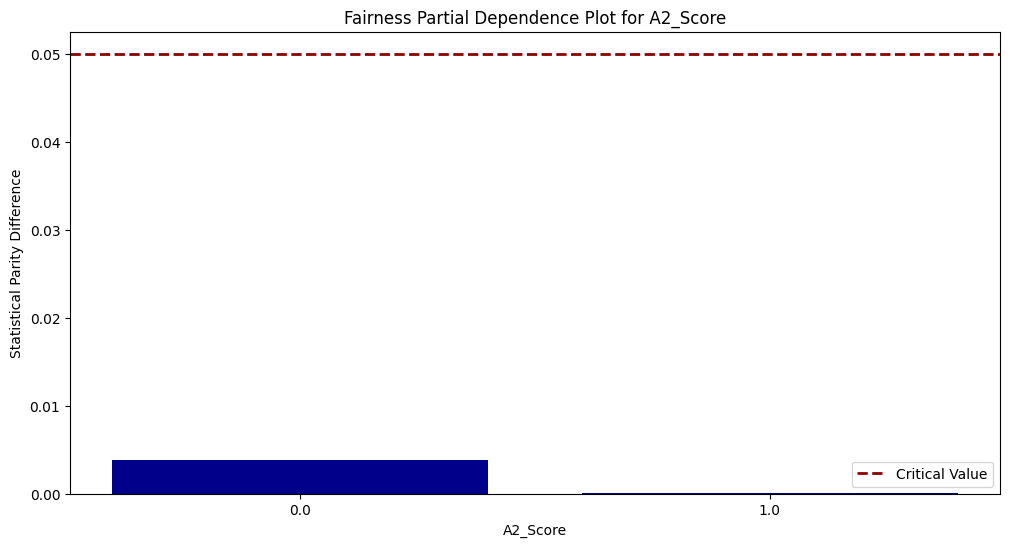

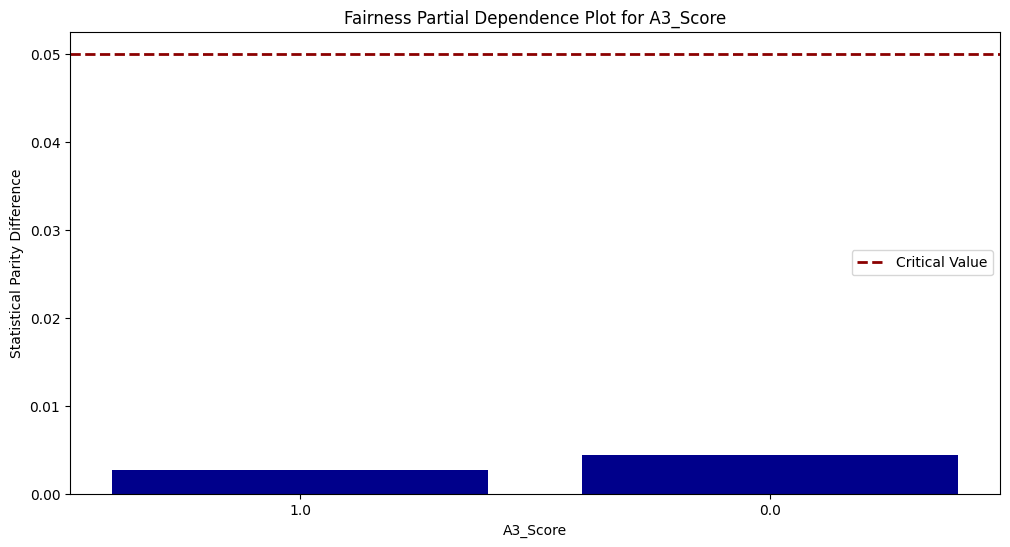

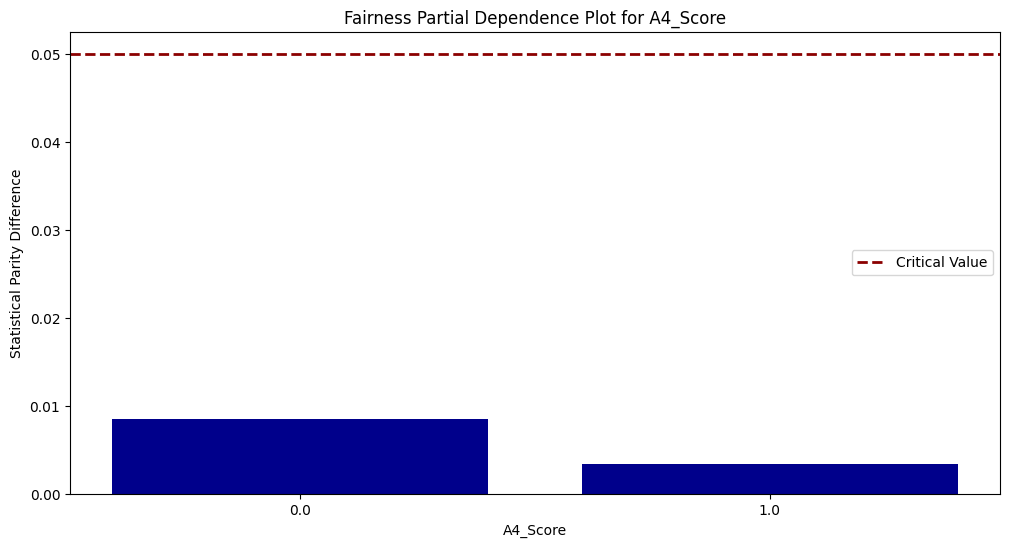

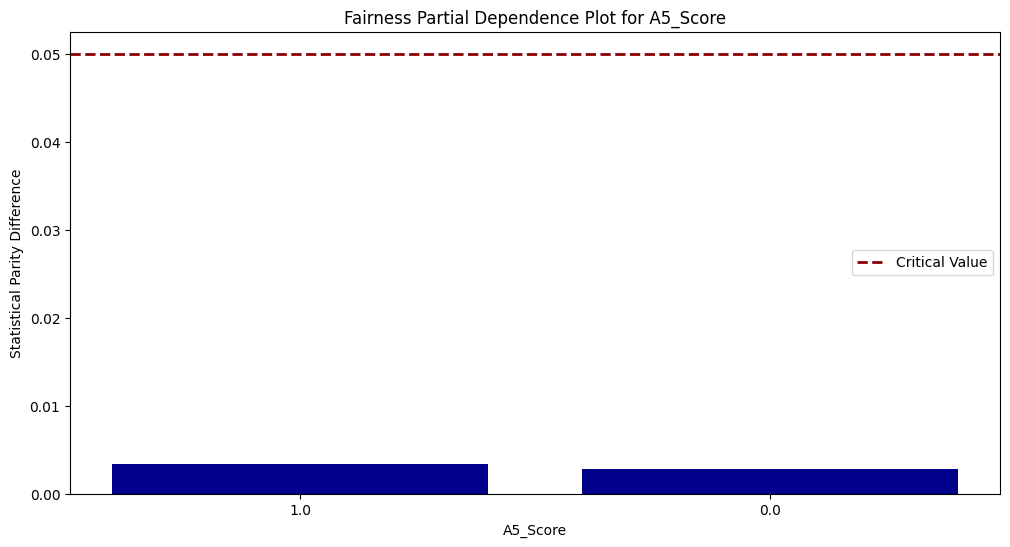

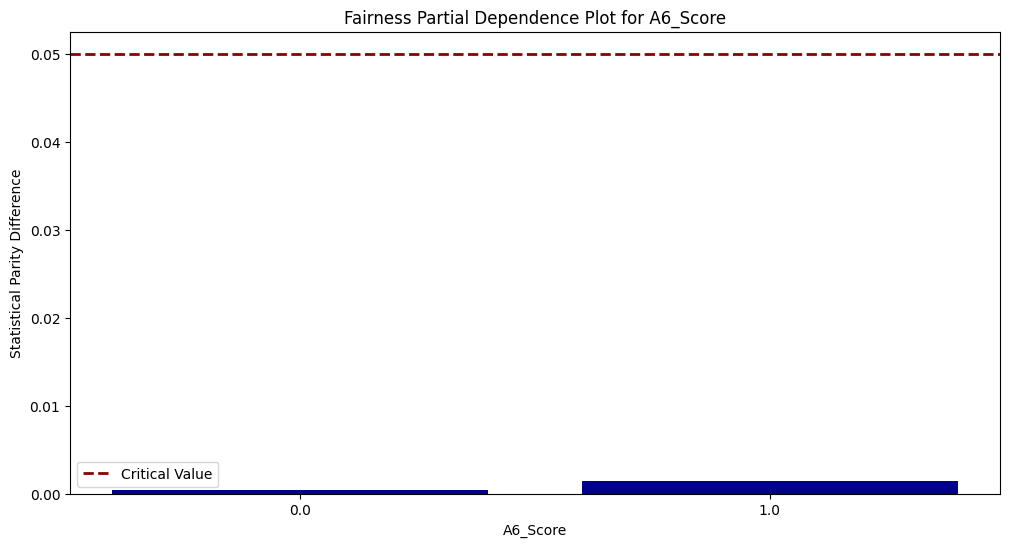

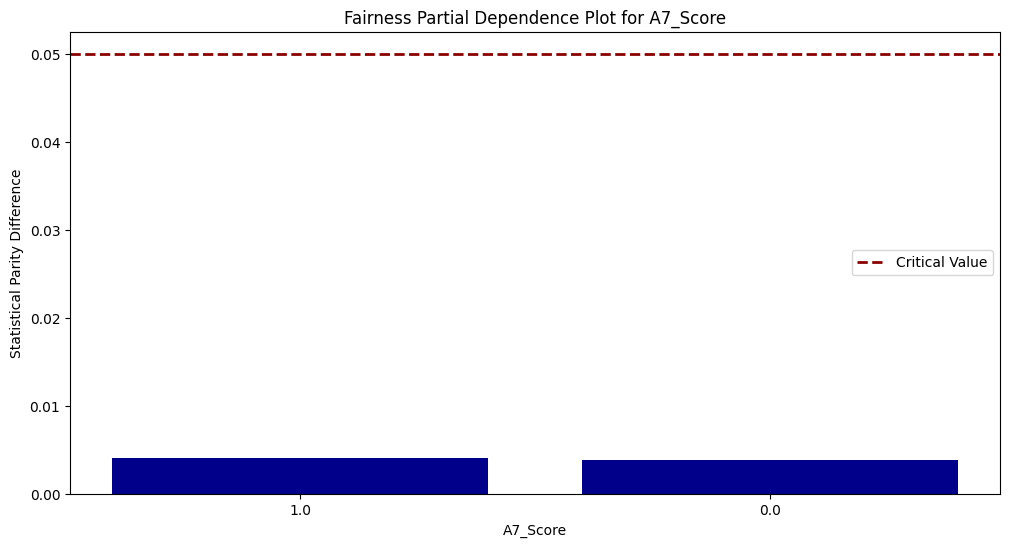

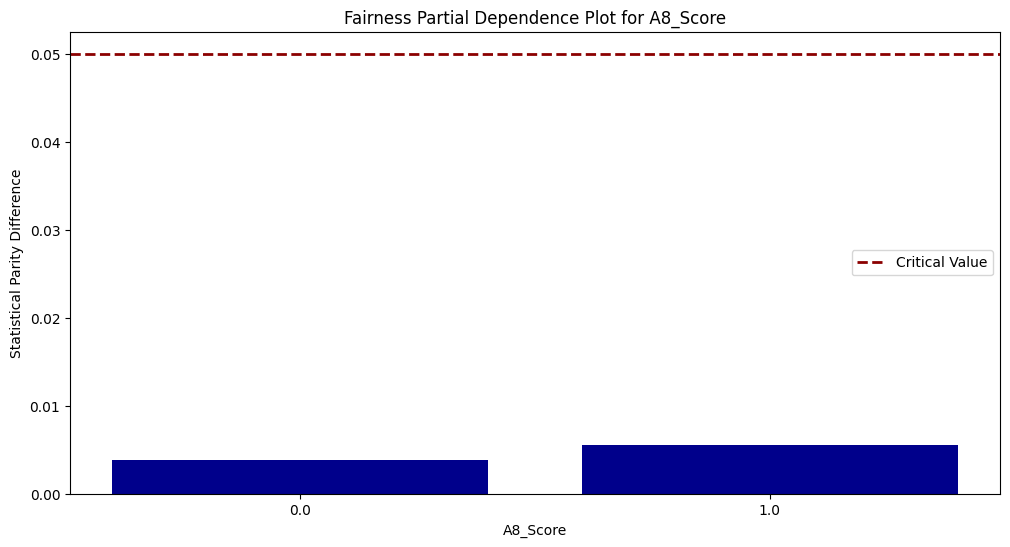

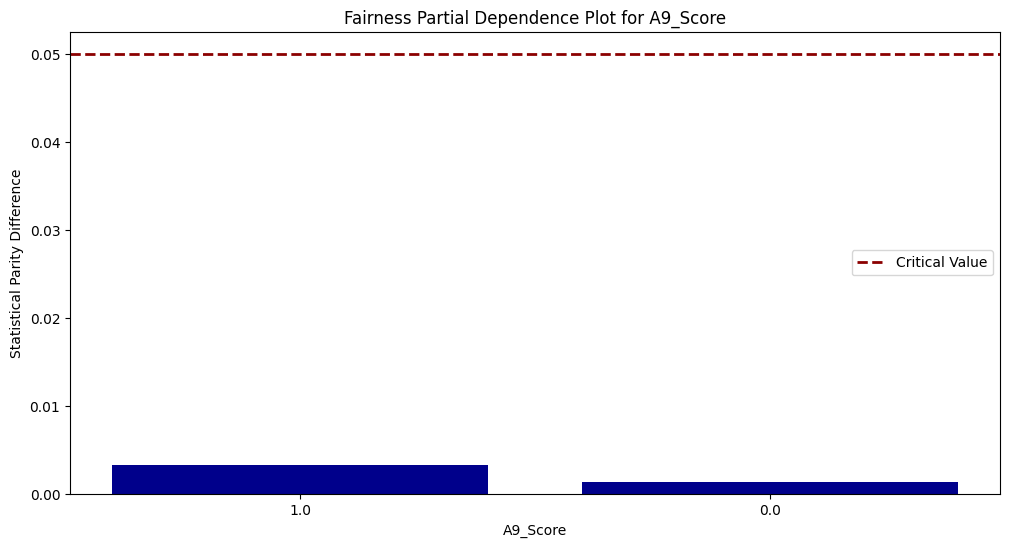

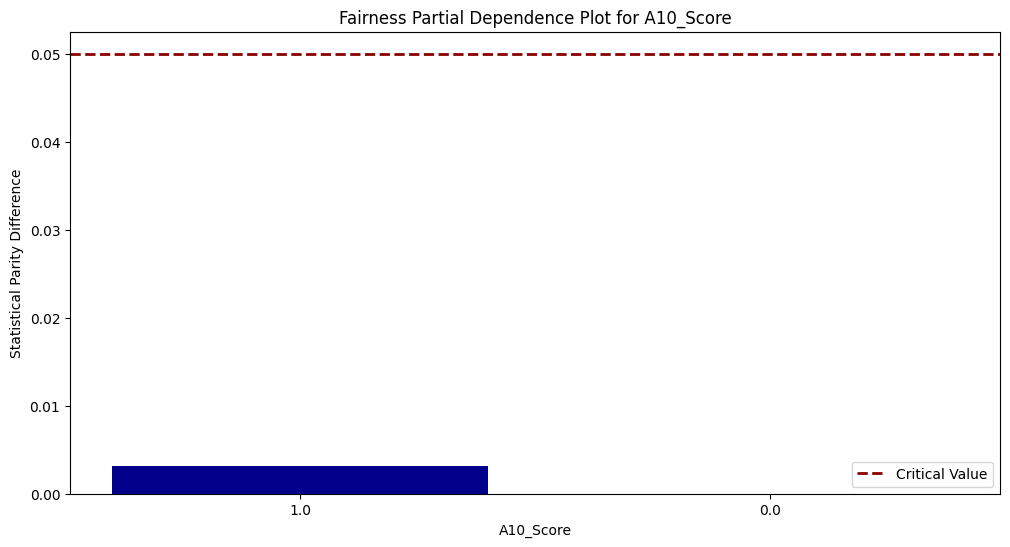

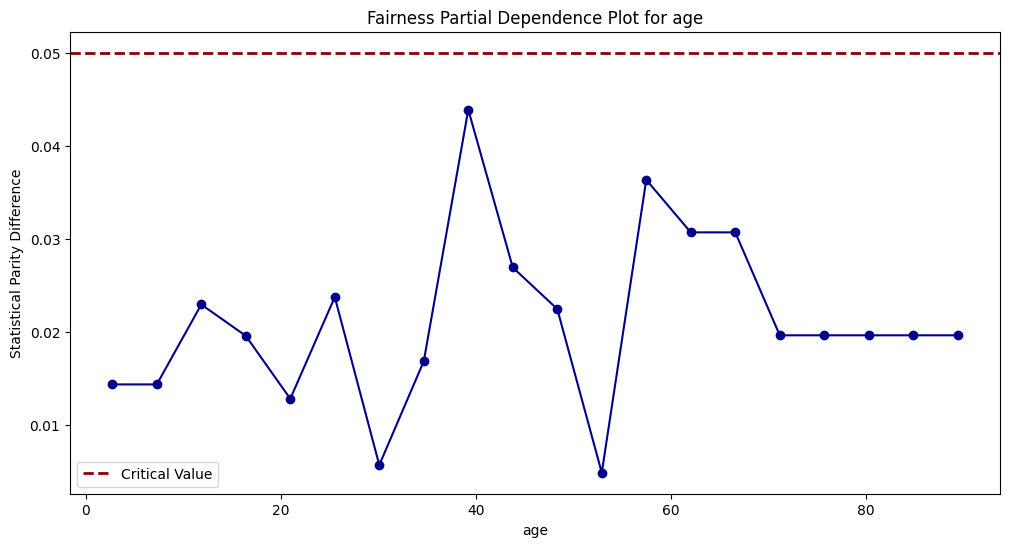

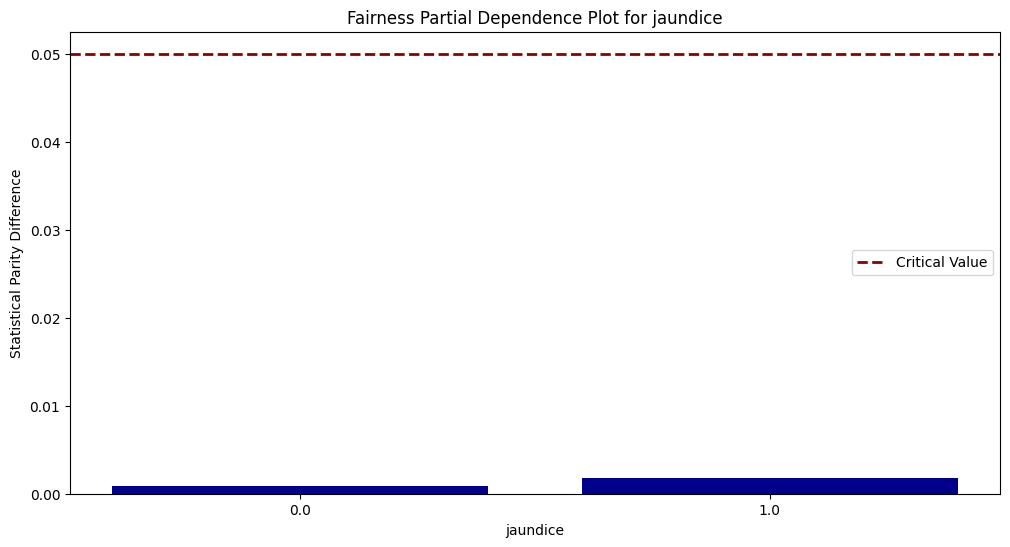

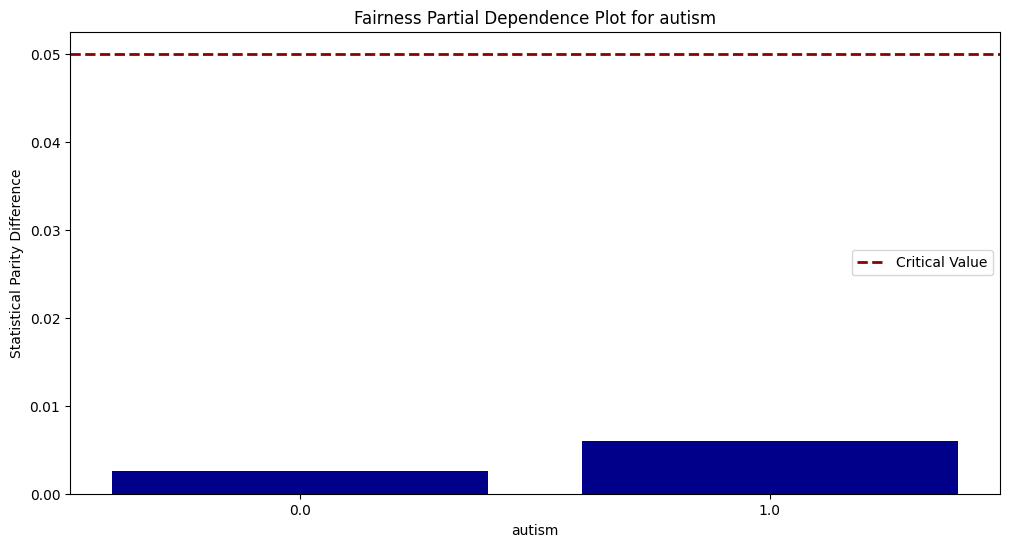

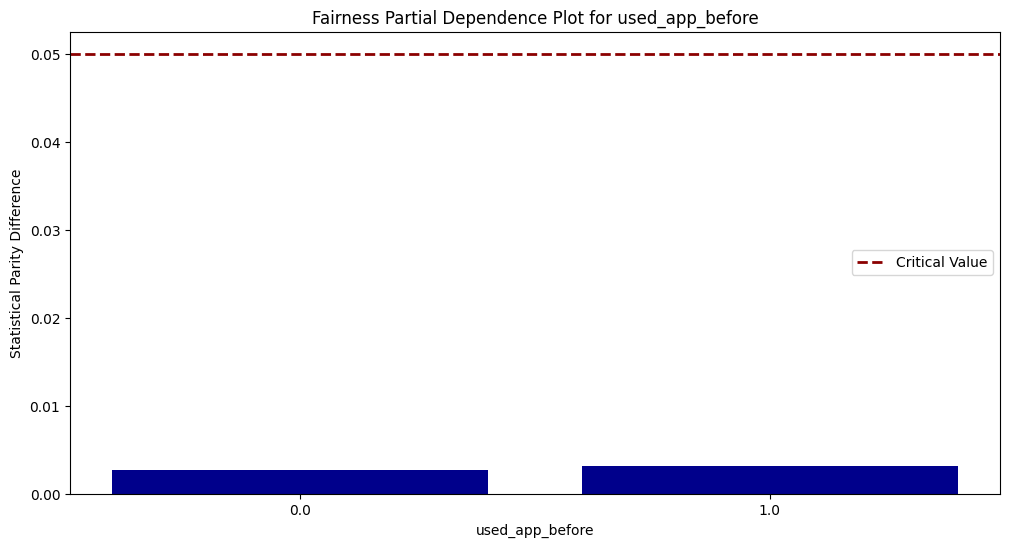

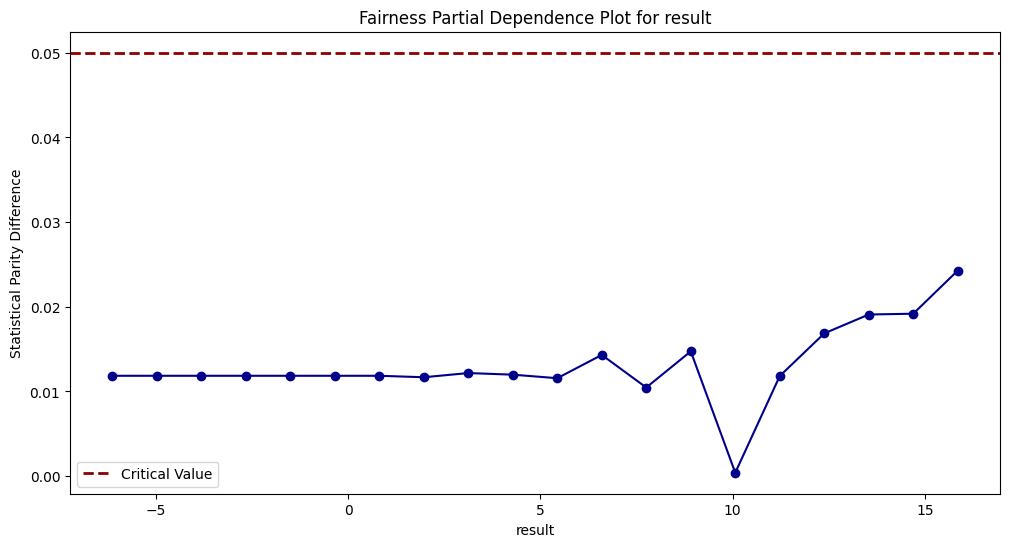

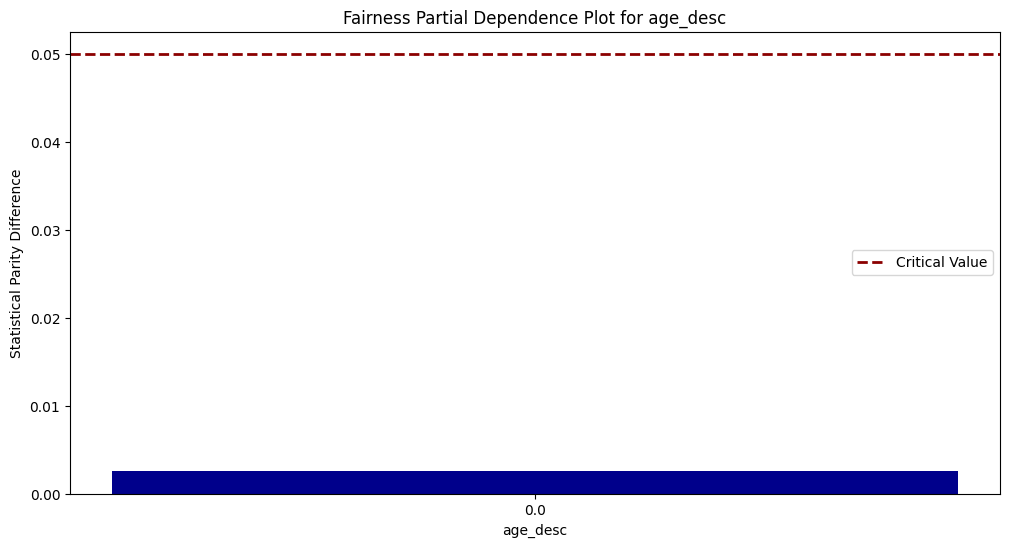

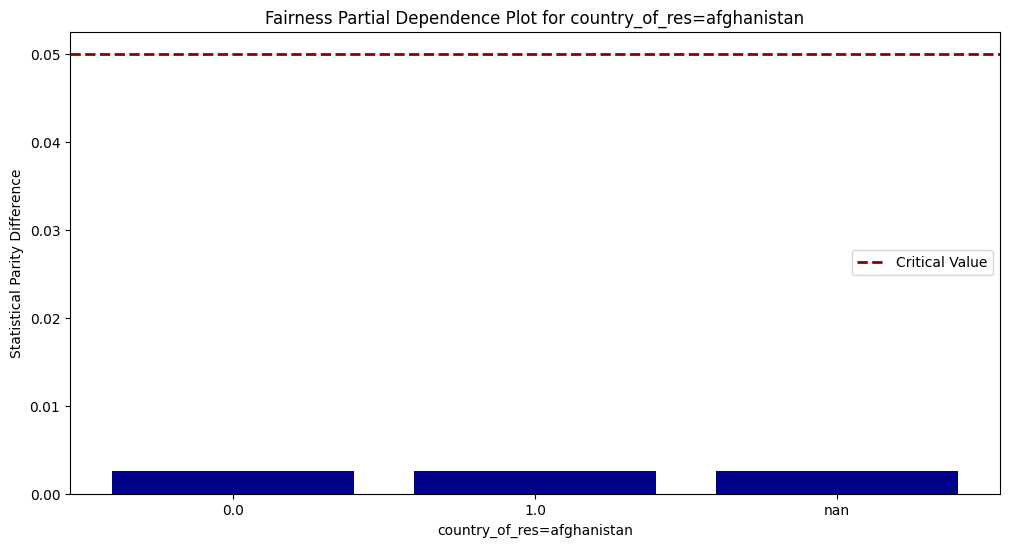

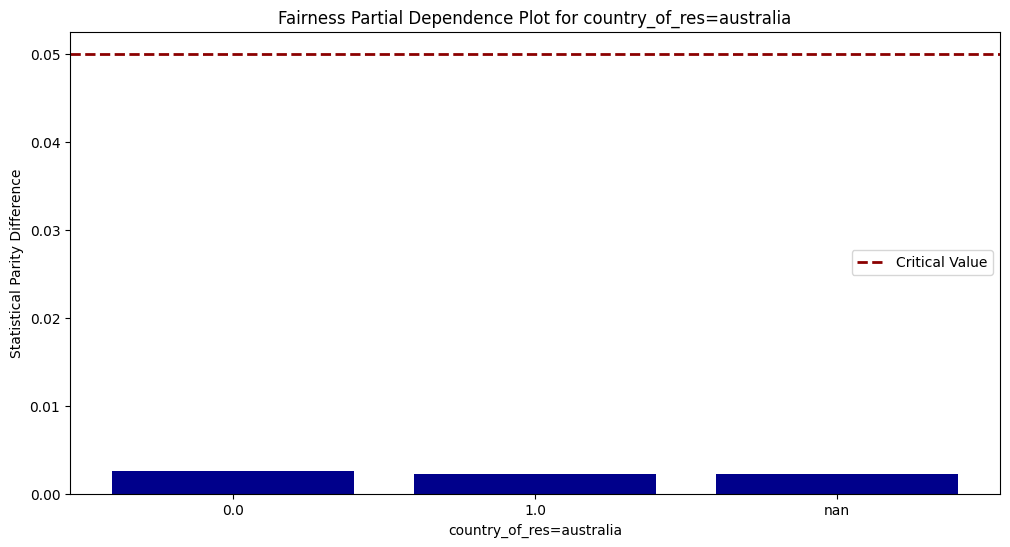

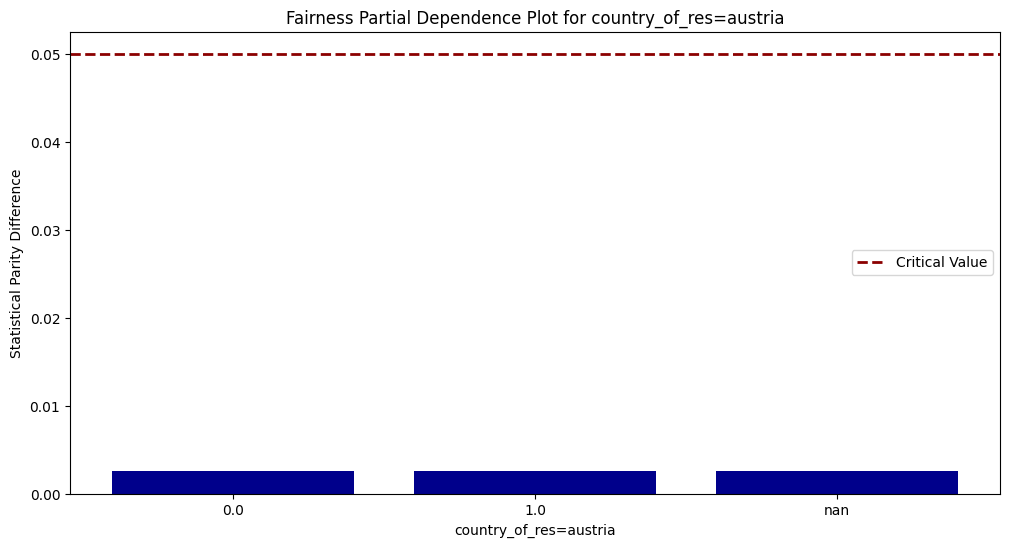

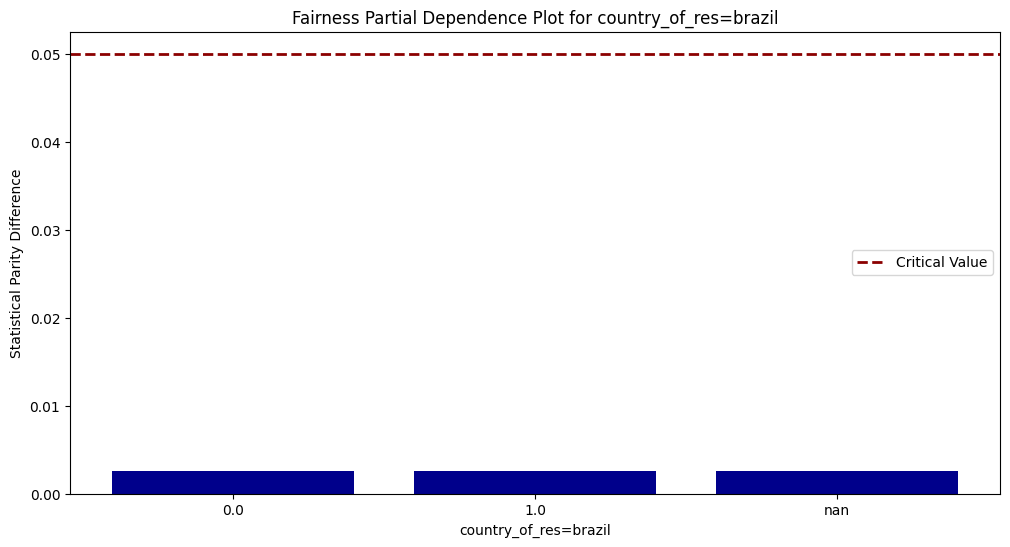

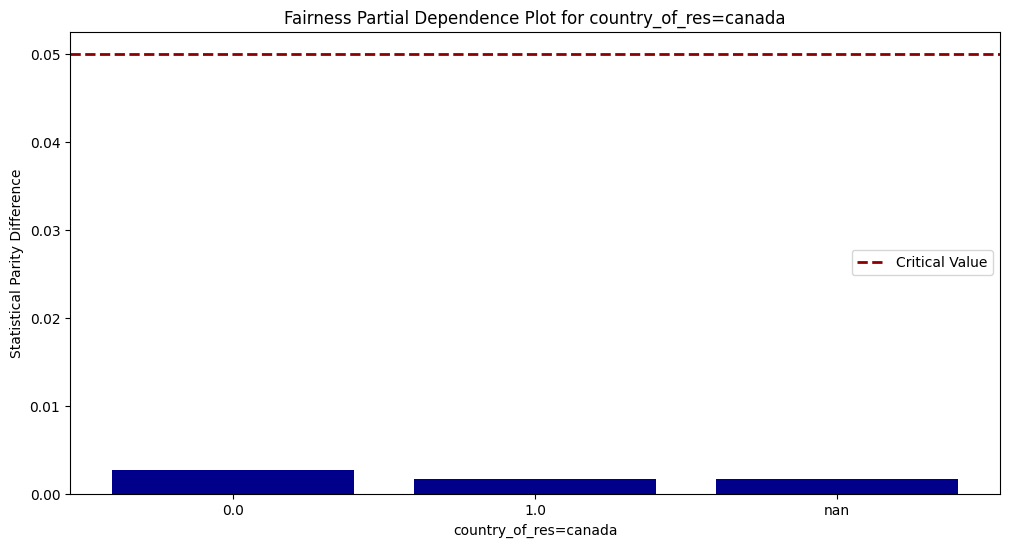

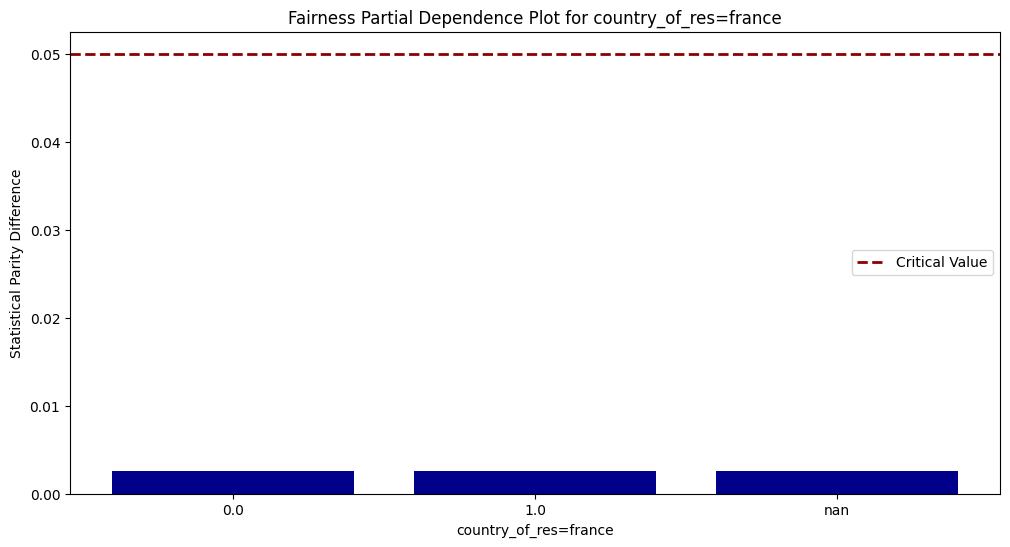

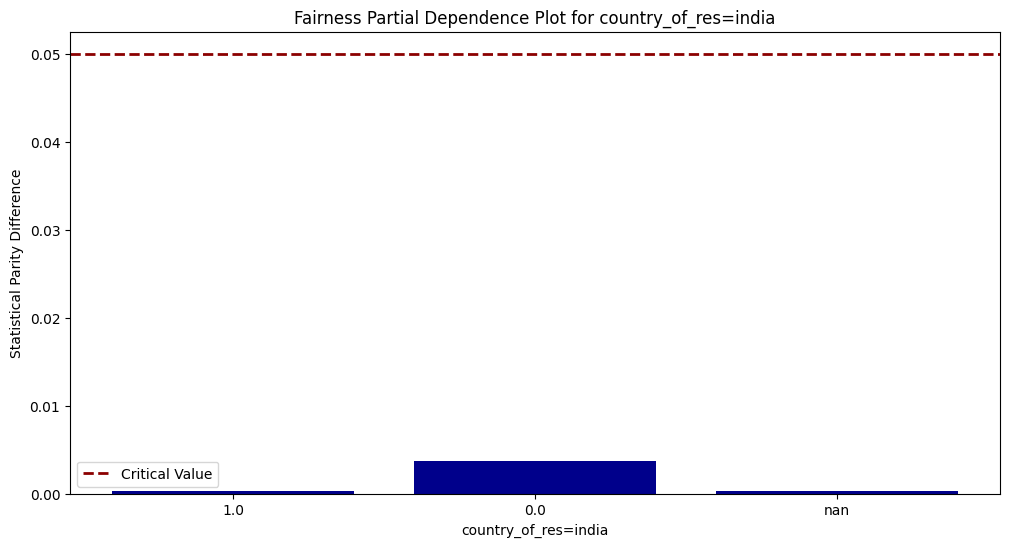

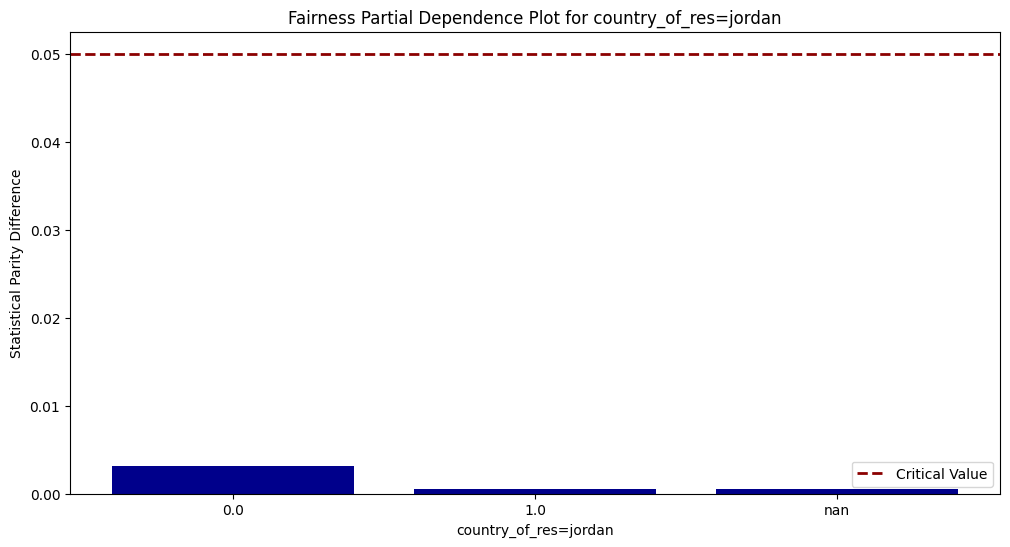

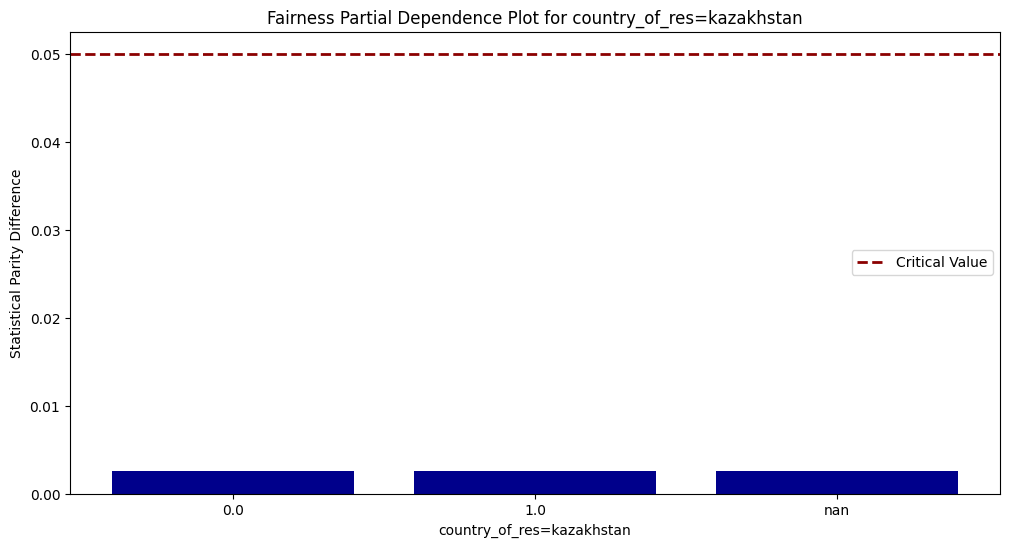

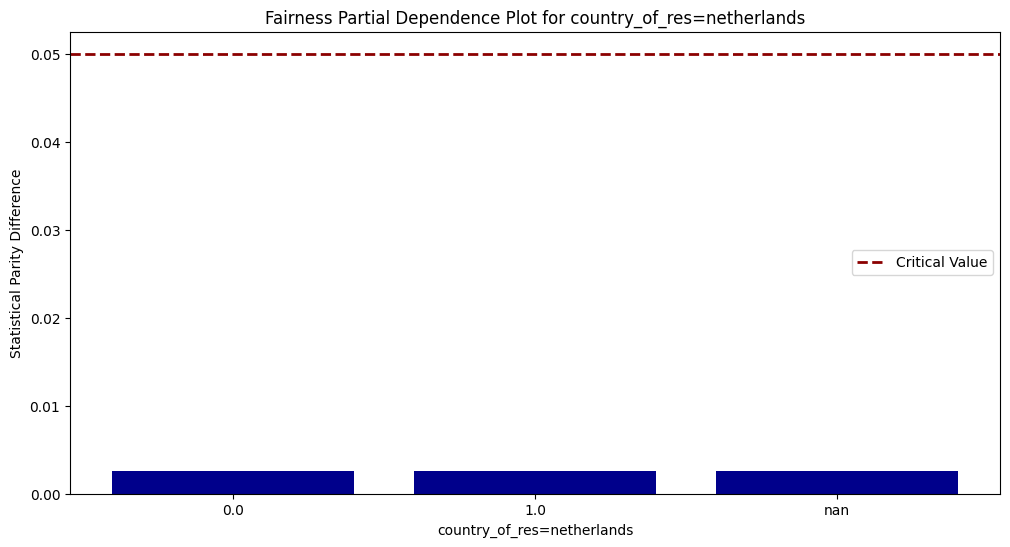

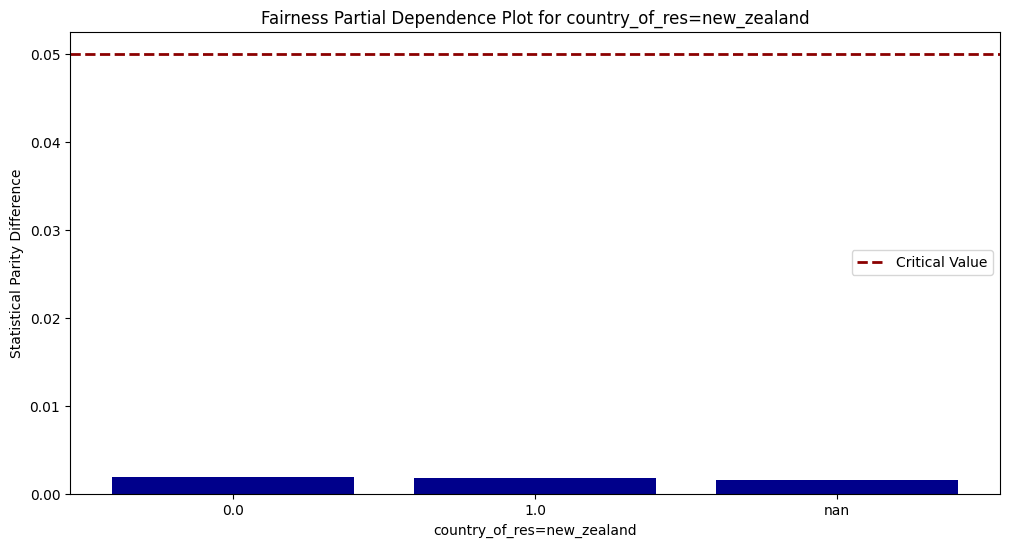

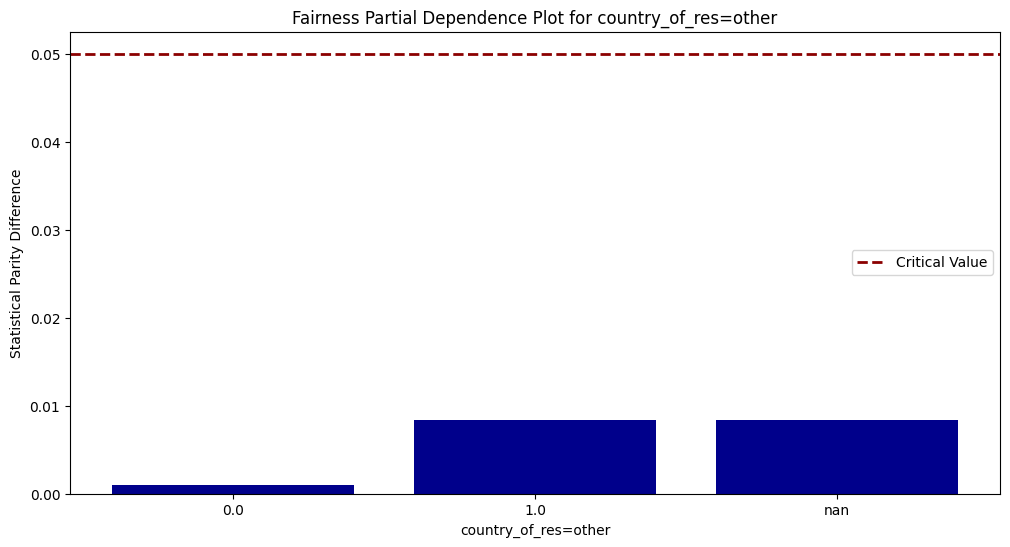

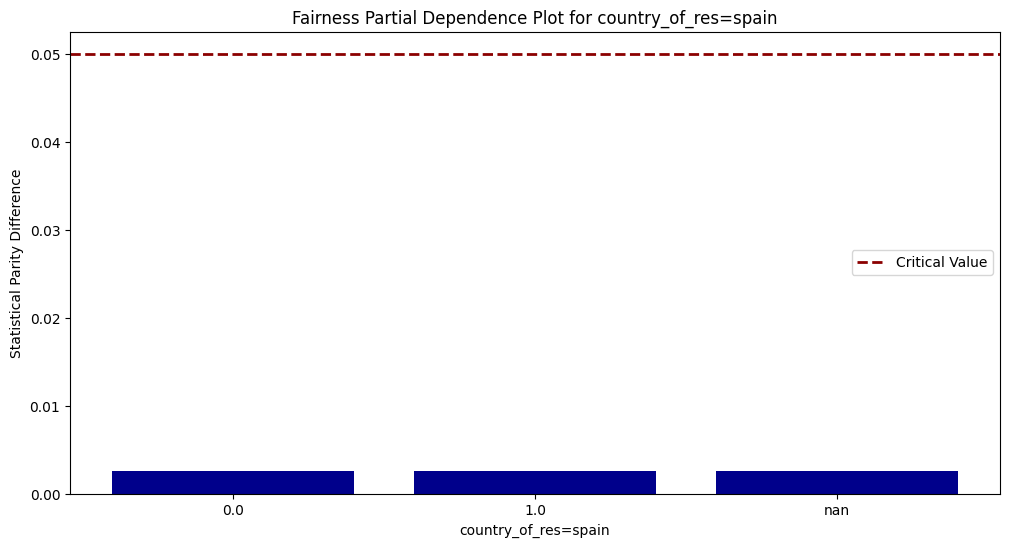

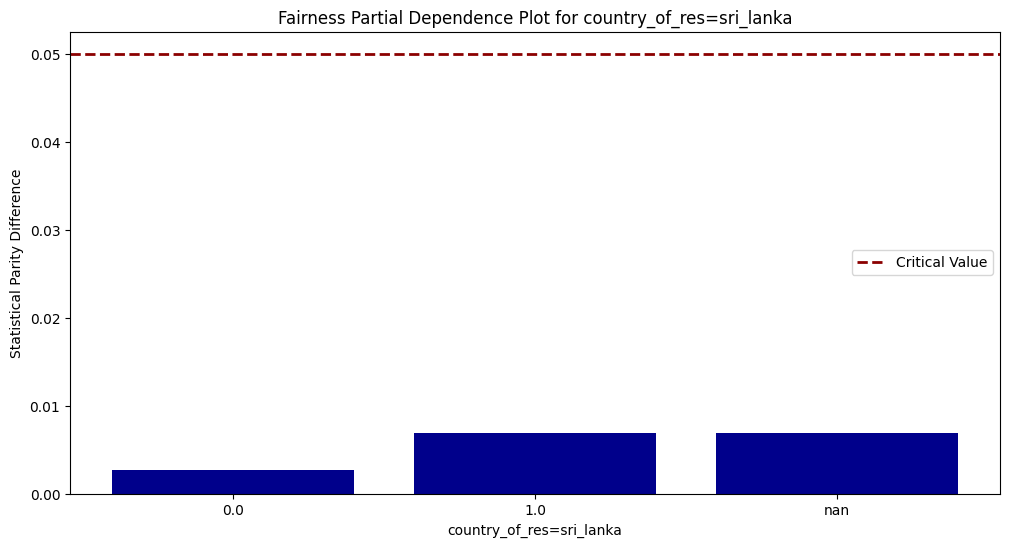

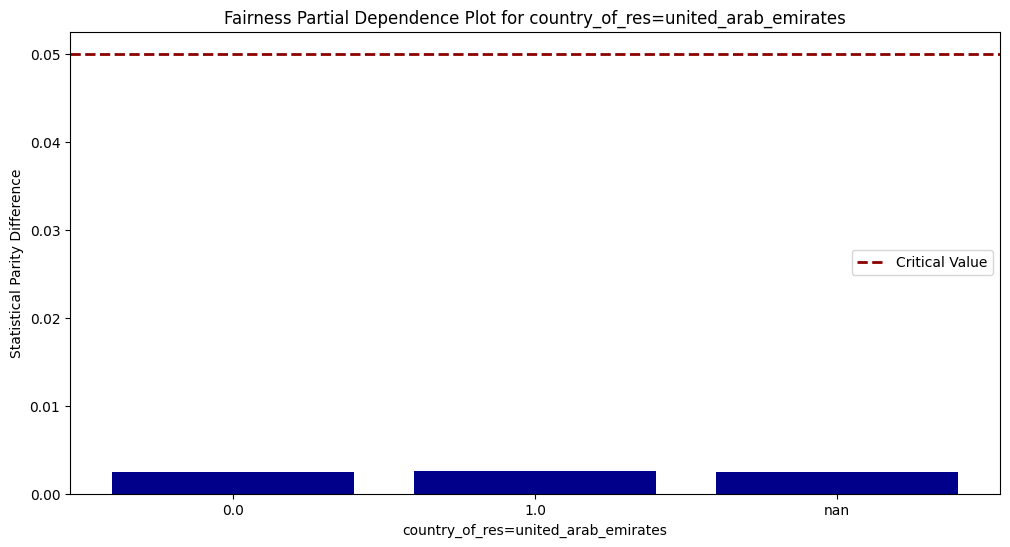

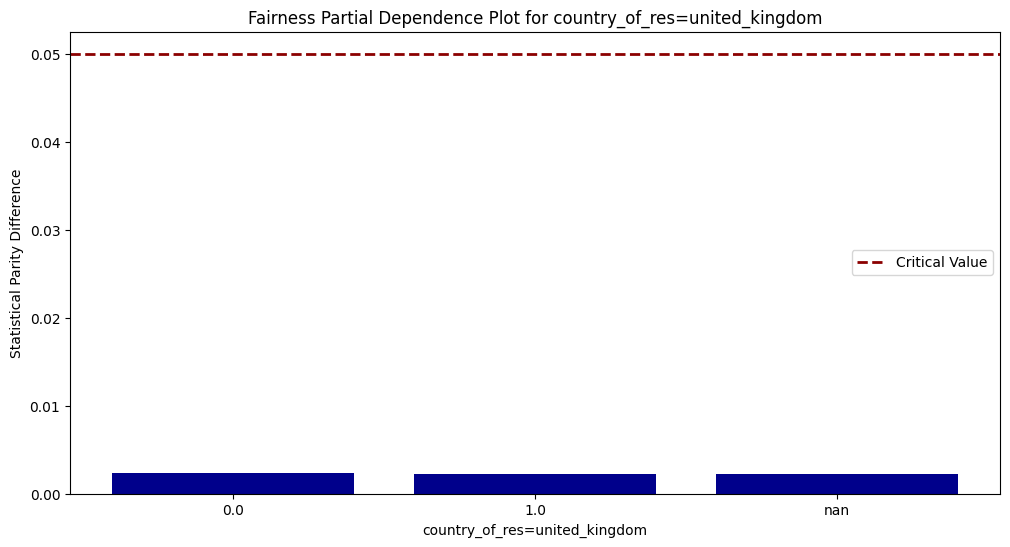

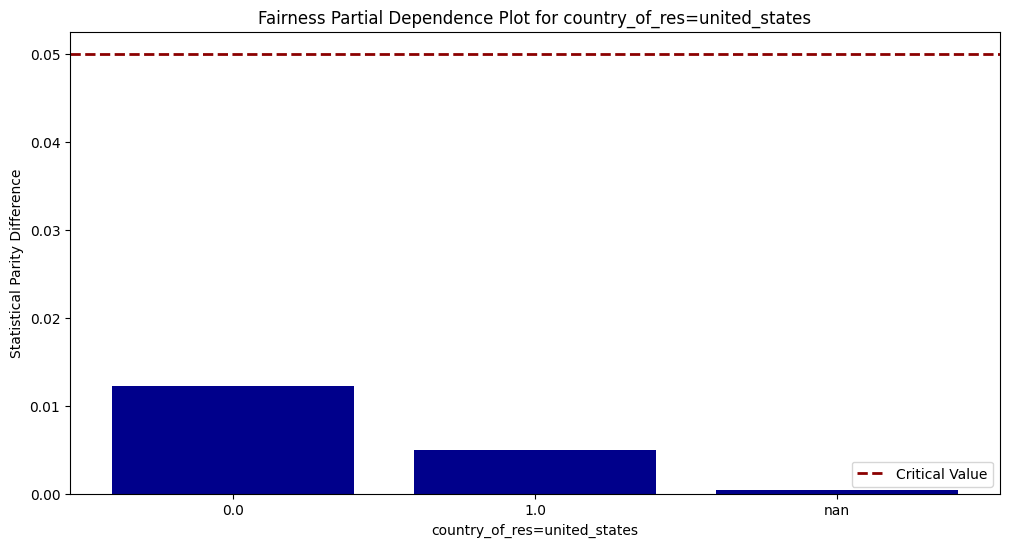

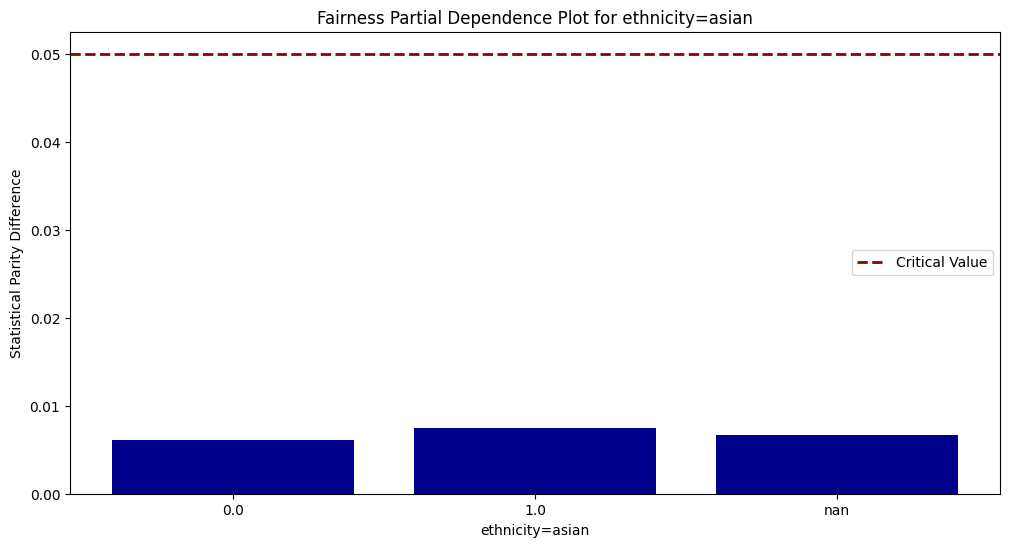

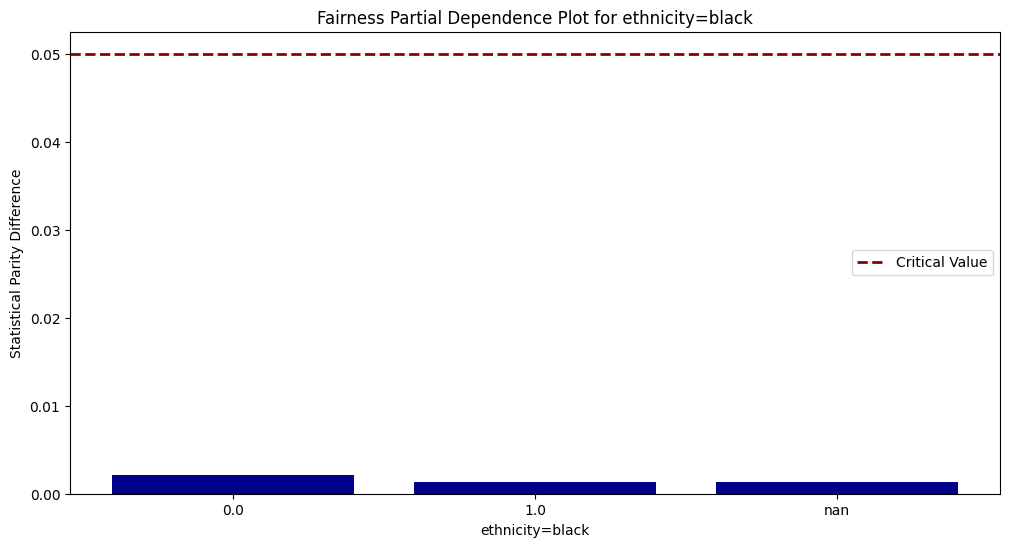

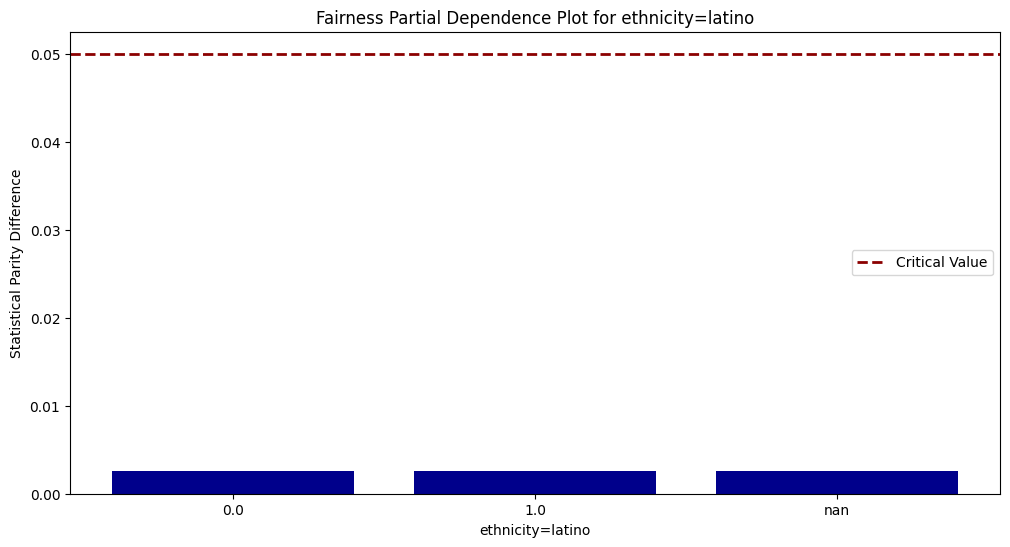

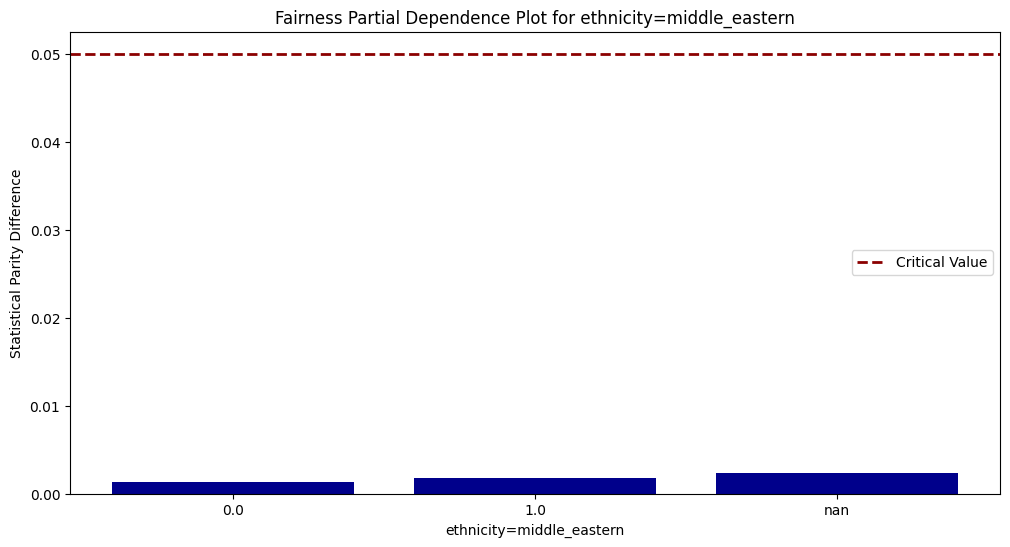

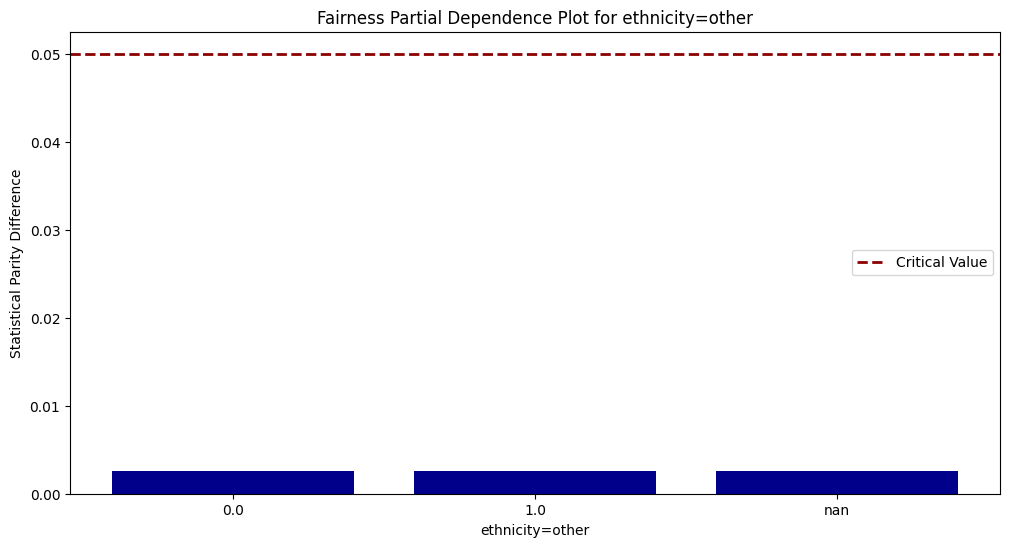

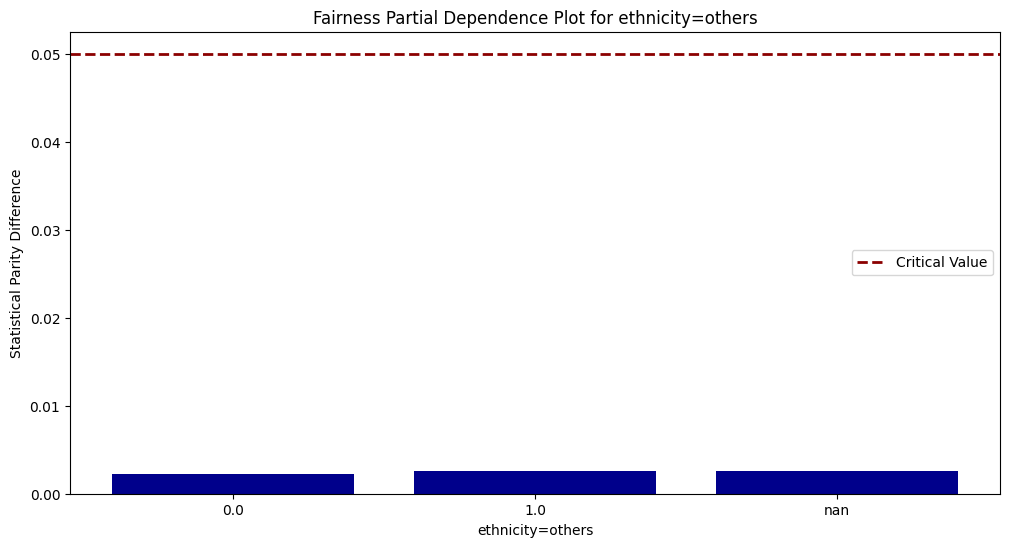

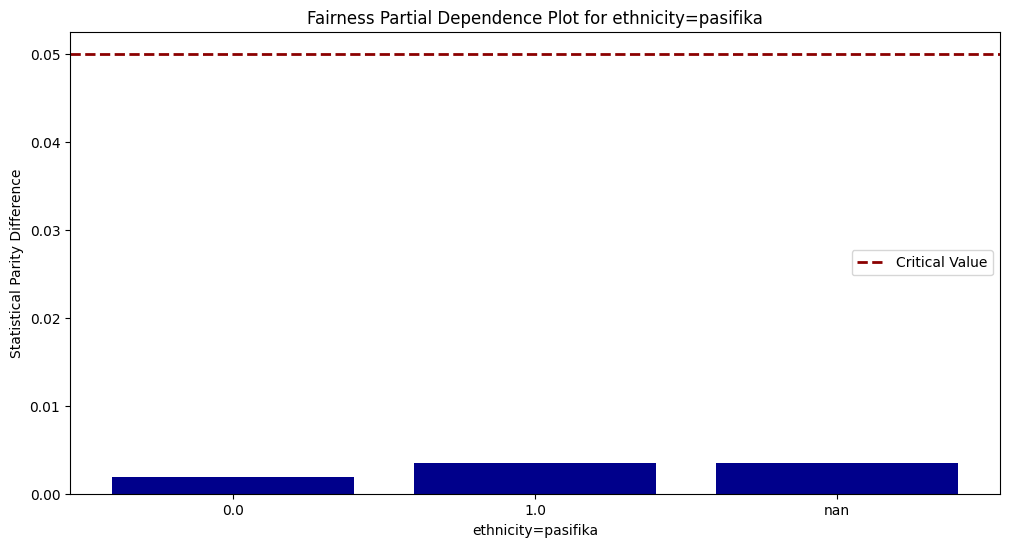

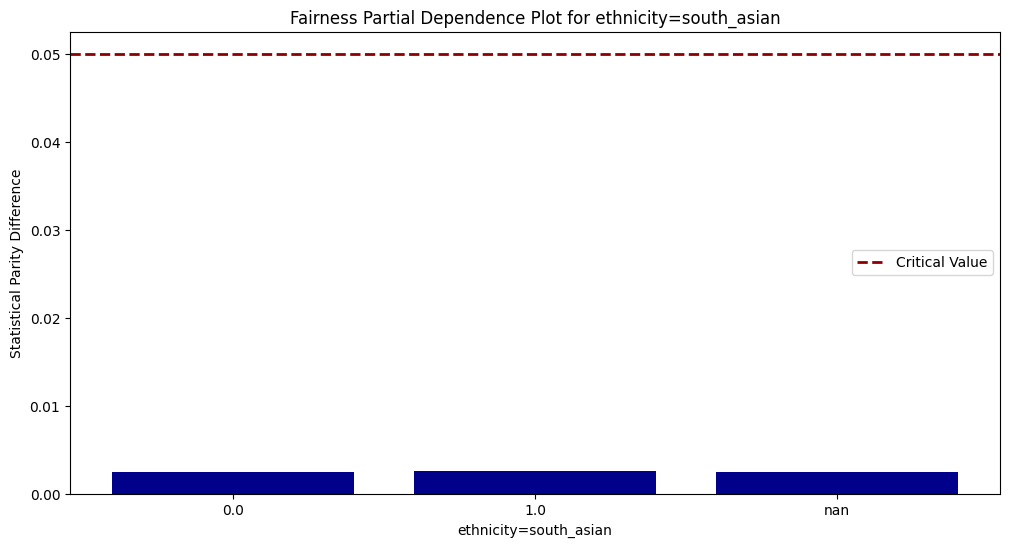

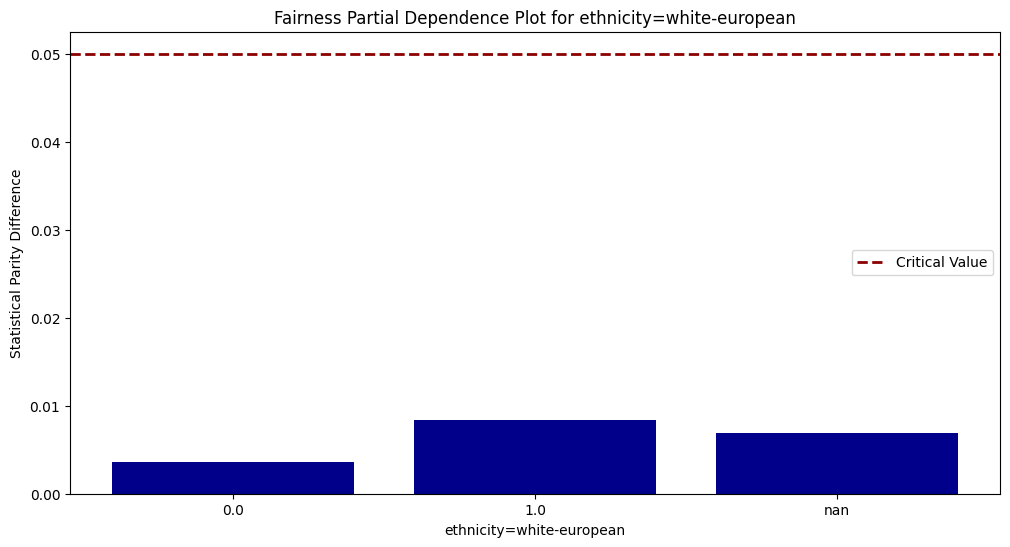

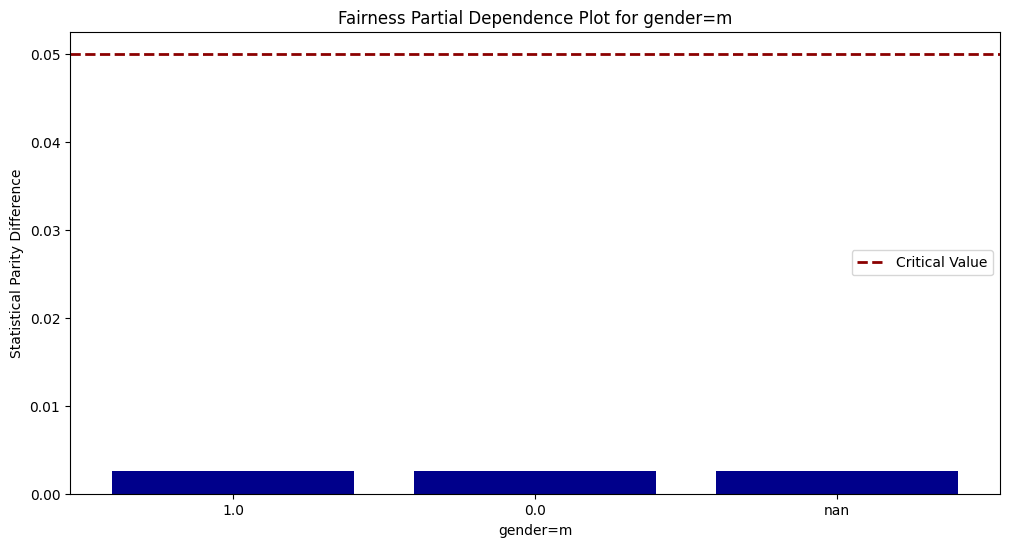

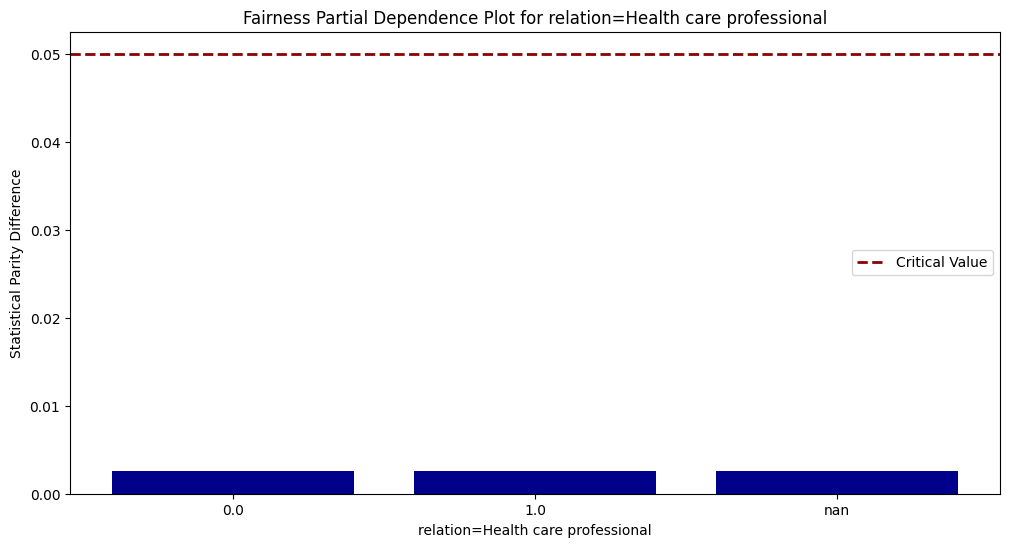

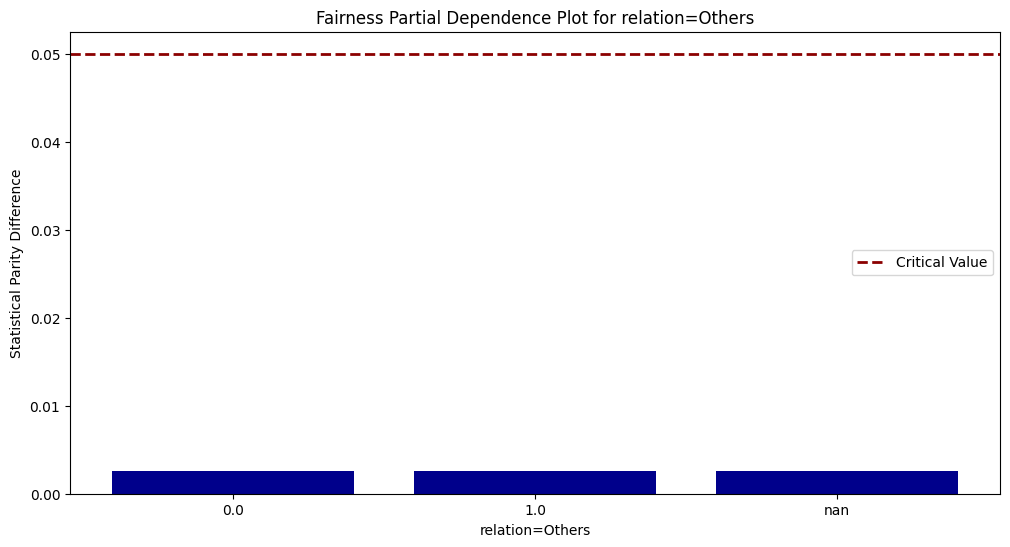

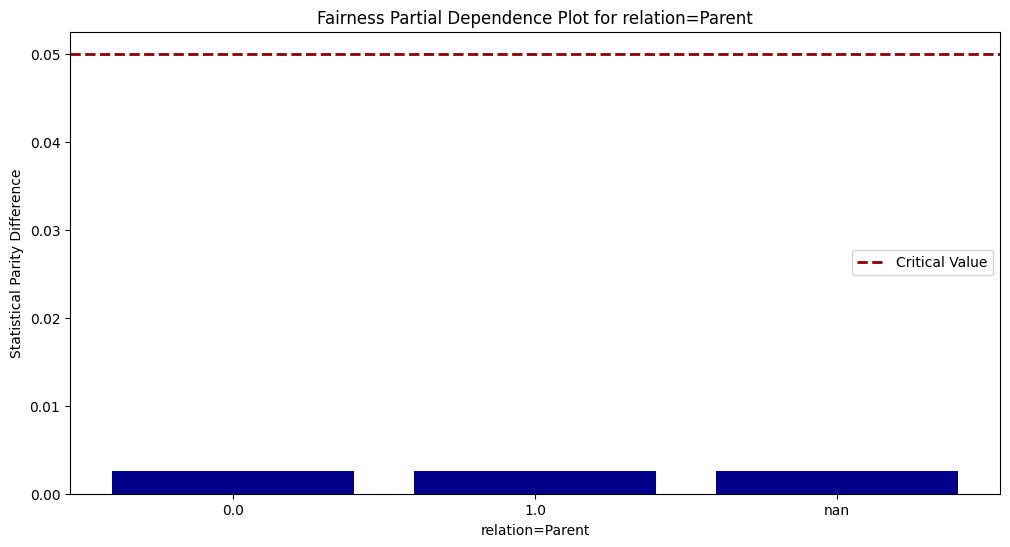

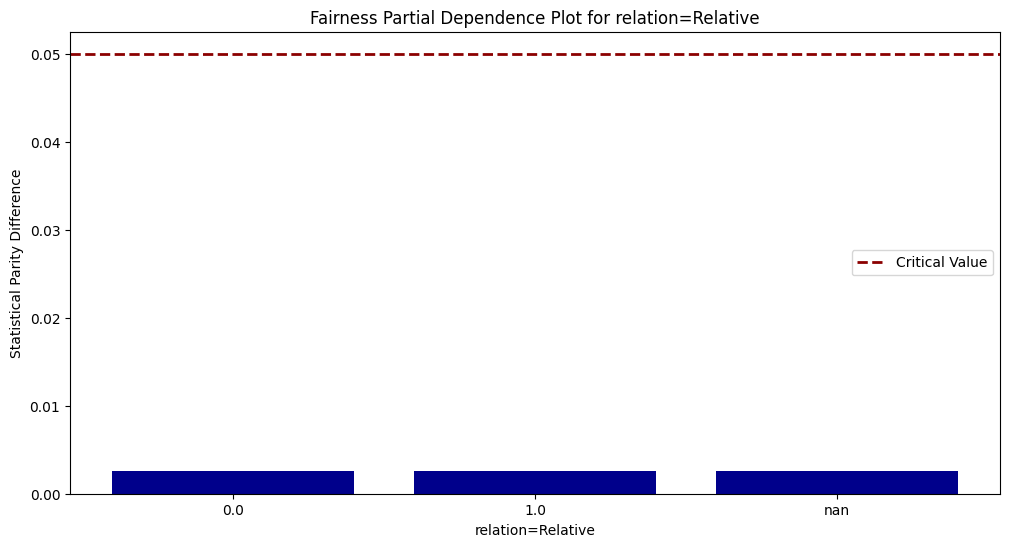

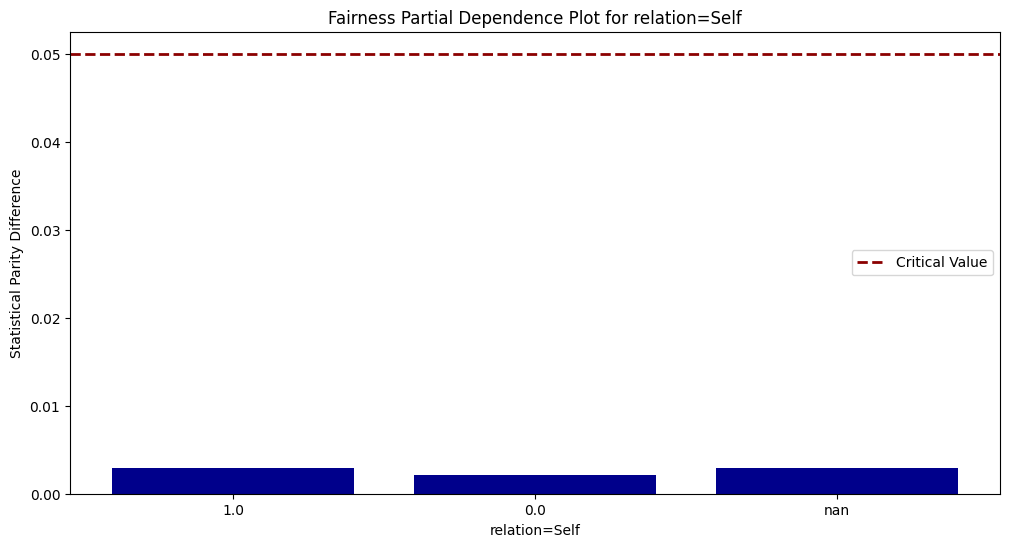

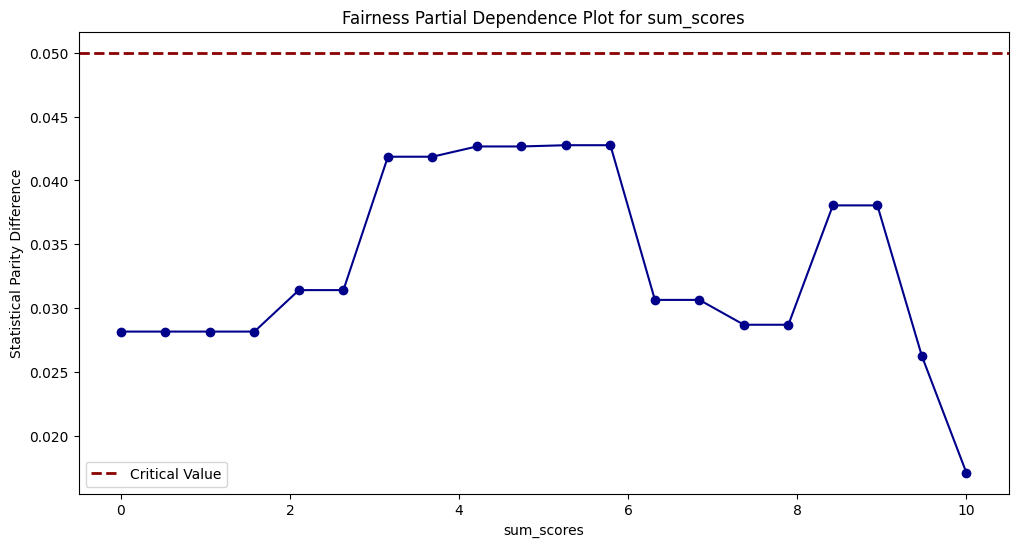

In [34]:
plot_fpdp_for_all_features(xgb_model, X, 'gender=f', protected_value=0, critical_value=0.05)

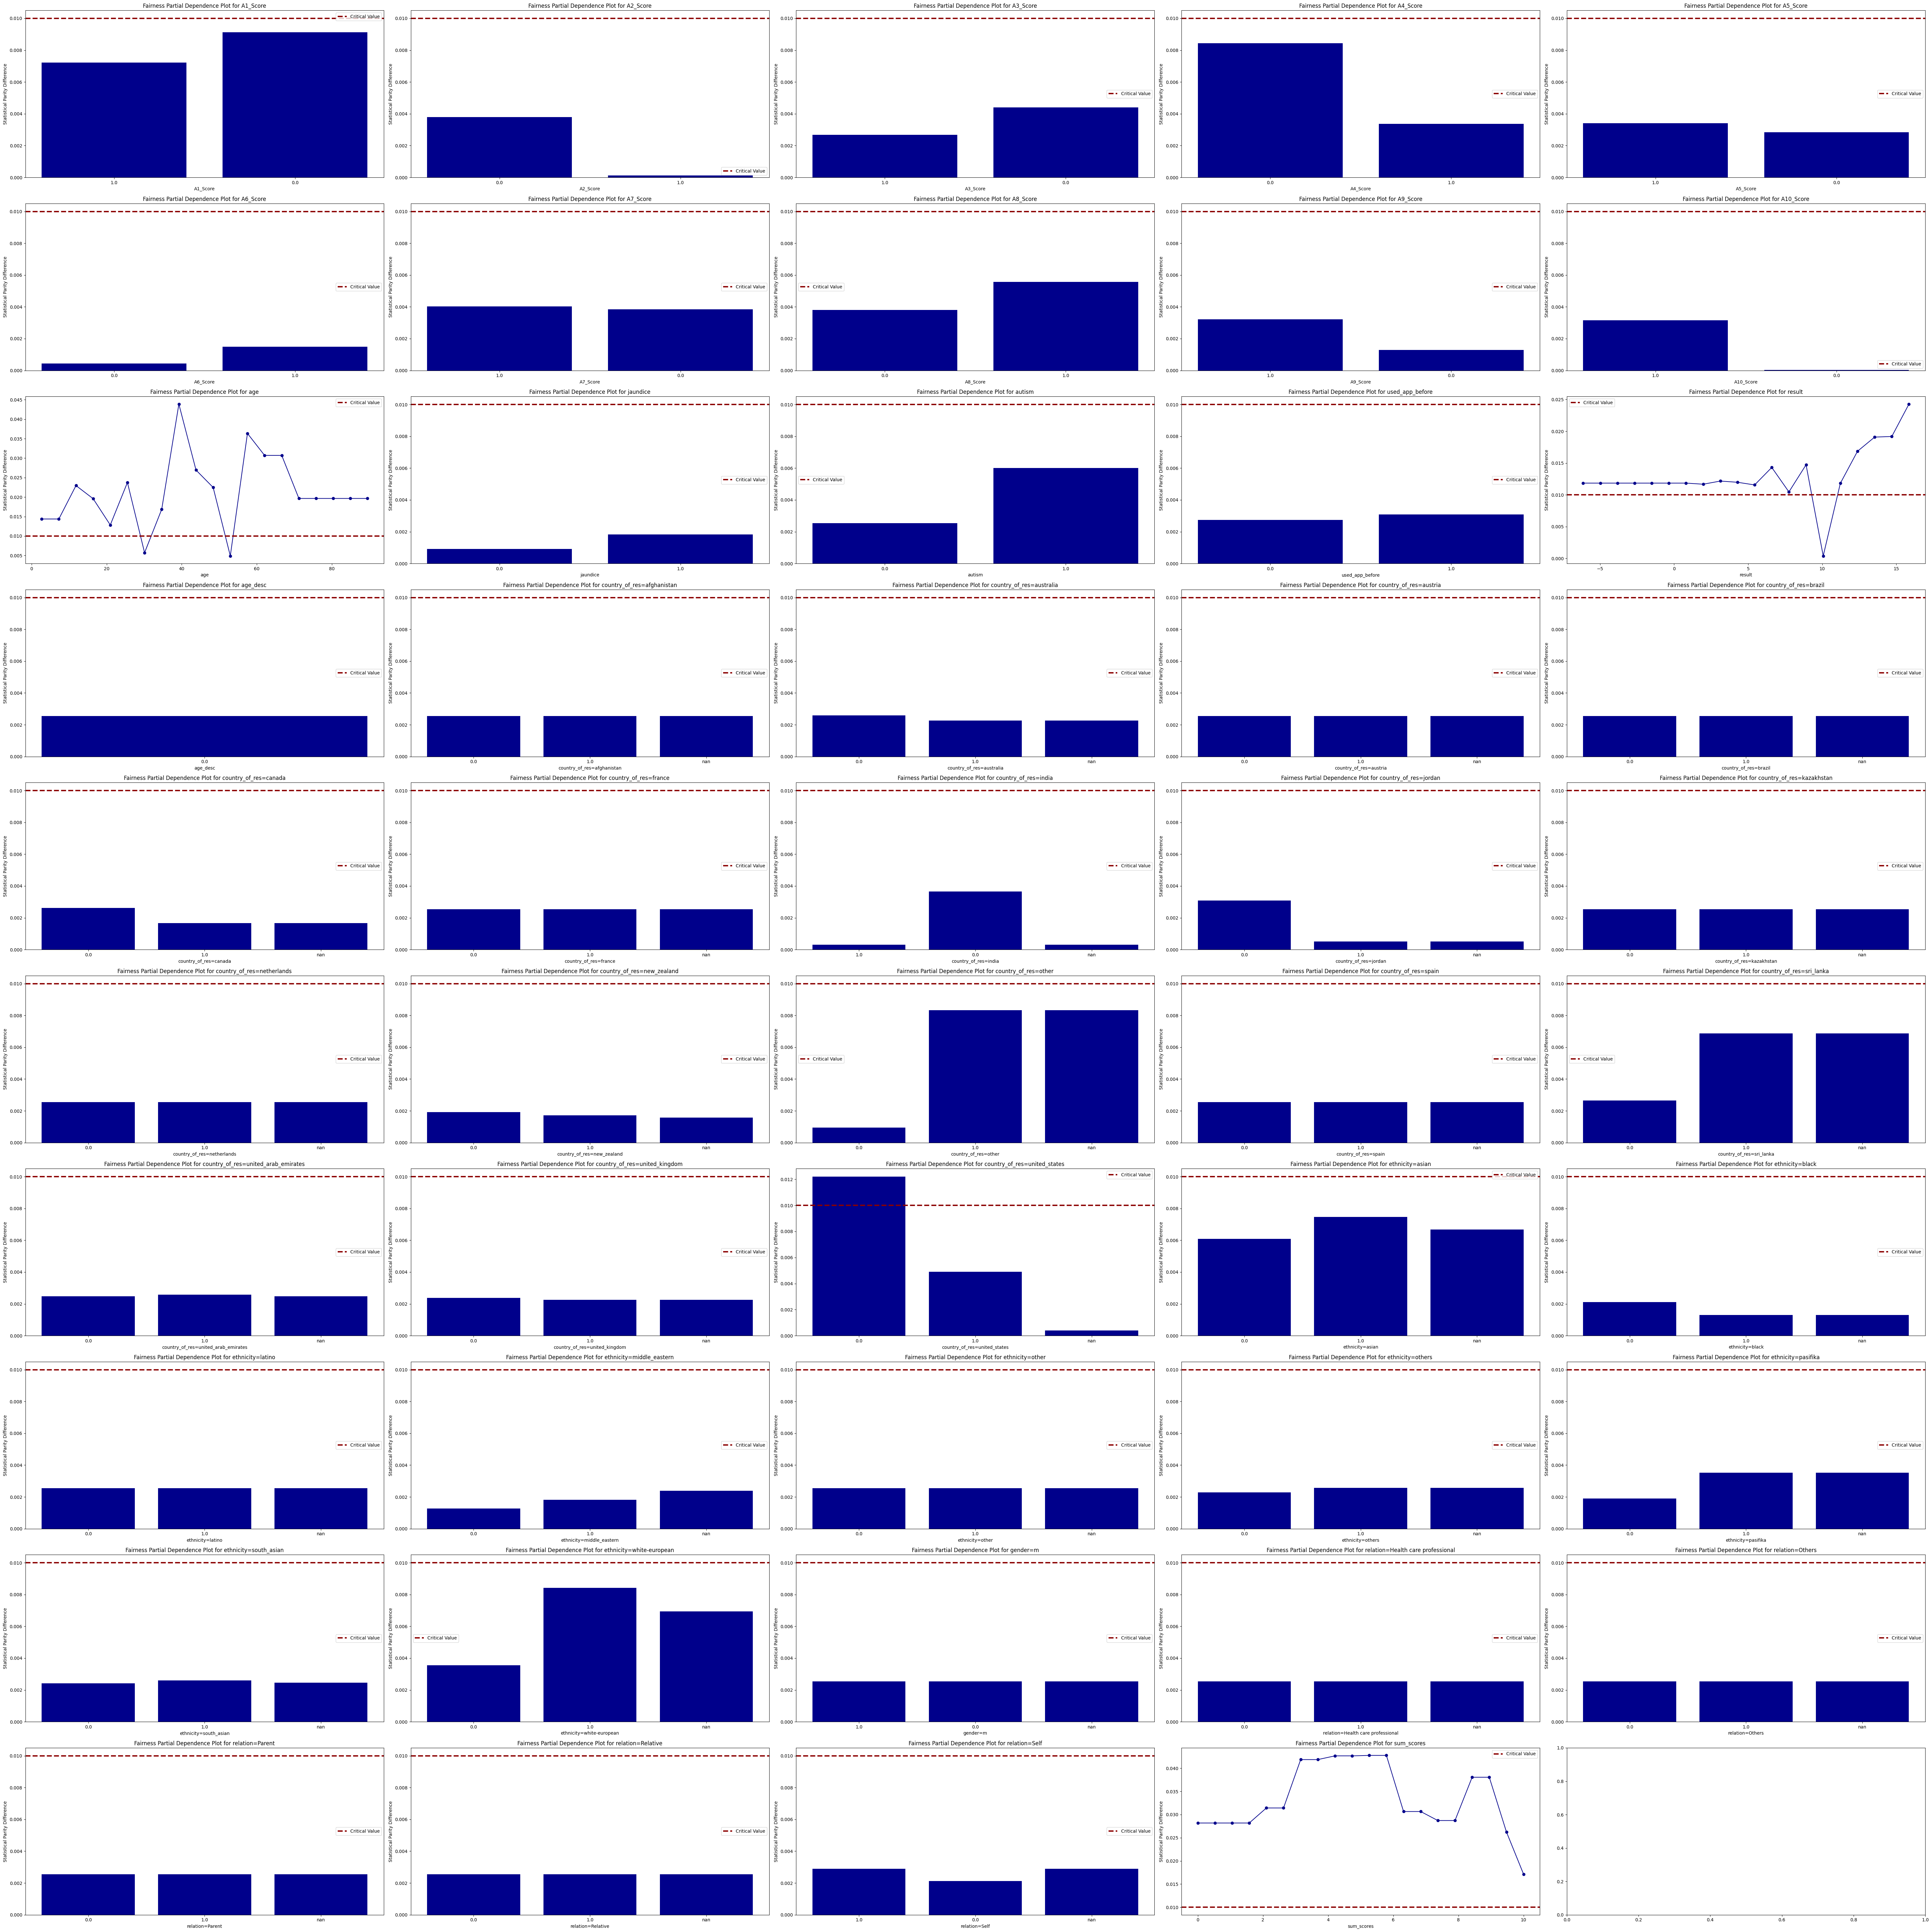

In [31]:
#Subplots FPDP for all features function
def plot_fpdp_for_all_features_subplot(model, X, sensitive_feature, protected_value, critical_value):
    features = [feature for feature in X.columns if feature != sensitive_feature and not feature.endswith(sensitive_feature)]
    num_features = len(features)

    cols = 5  # Define how many columns 
    rows = num_features // cols + (num_features % cols > 0)  # Calculate the required number of rows
    fig, axs = plt.subplots(rows, cols, figsize=(12 * cols, 6 * rows))  # Adjust the figure size 

    for i, feature in enumerate(features):
        row = i // cols
        col = i % cols
        ax = axs[row, col] if rows > 1 else axs[col]  # Adjust for the case of a single row

        is_categorical = True if 'Score' in feature or X[feature].nunique() < 10 else False
        values, parity_differences = [], []

        if is_categorical:
            categories = X[feature].unique()
            for category in categories:
                parity_diff = statistical_parity(model, X, sensitive_feature, protected_value, feature, category)
                values.append(category)
                parity_differences.append(parity_diff)
            
            ax.bar([str(v) for v in values], parity_differences, color='darkblue')
        
        else:
            min_value, max_value = X[feature].min(), X[feature].max()
            values = np.linspace(min_value, max_value, num=20)
            for value in values:
                parity_diff = statistical_parity(model, X, sensitive_feature, protected_value, feature, value)
                parity_differences.append(parity_diff)
            
            ax.plot(values, parity_differences, marker='o', linestyle='-', color='darkblue')

        ax.axhline(y=critical_value, color='darkred', linestyle='--', label='Critical Value',linewidth=3)
        ax.set_xlabel(feature)
        ax.set_ylabel('Statistical Parity Difference')
        ax.set_title(f'Fairness Partial Dependence Plot for {feature}')
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_fpdp_for_all_features_subplot(xgb_model, X, 'gender=f', protected_value=0, critical_value=0.01)



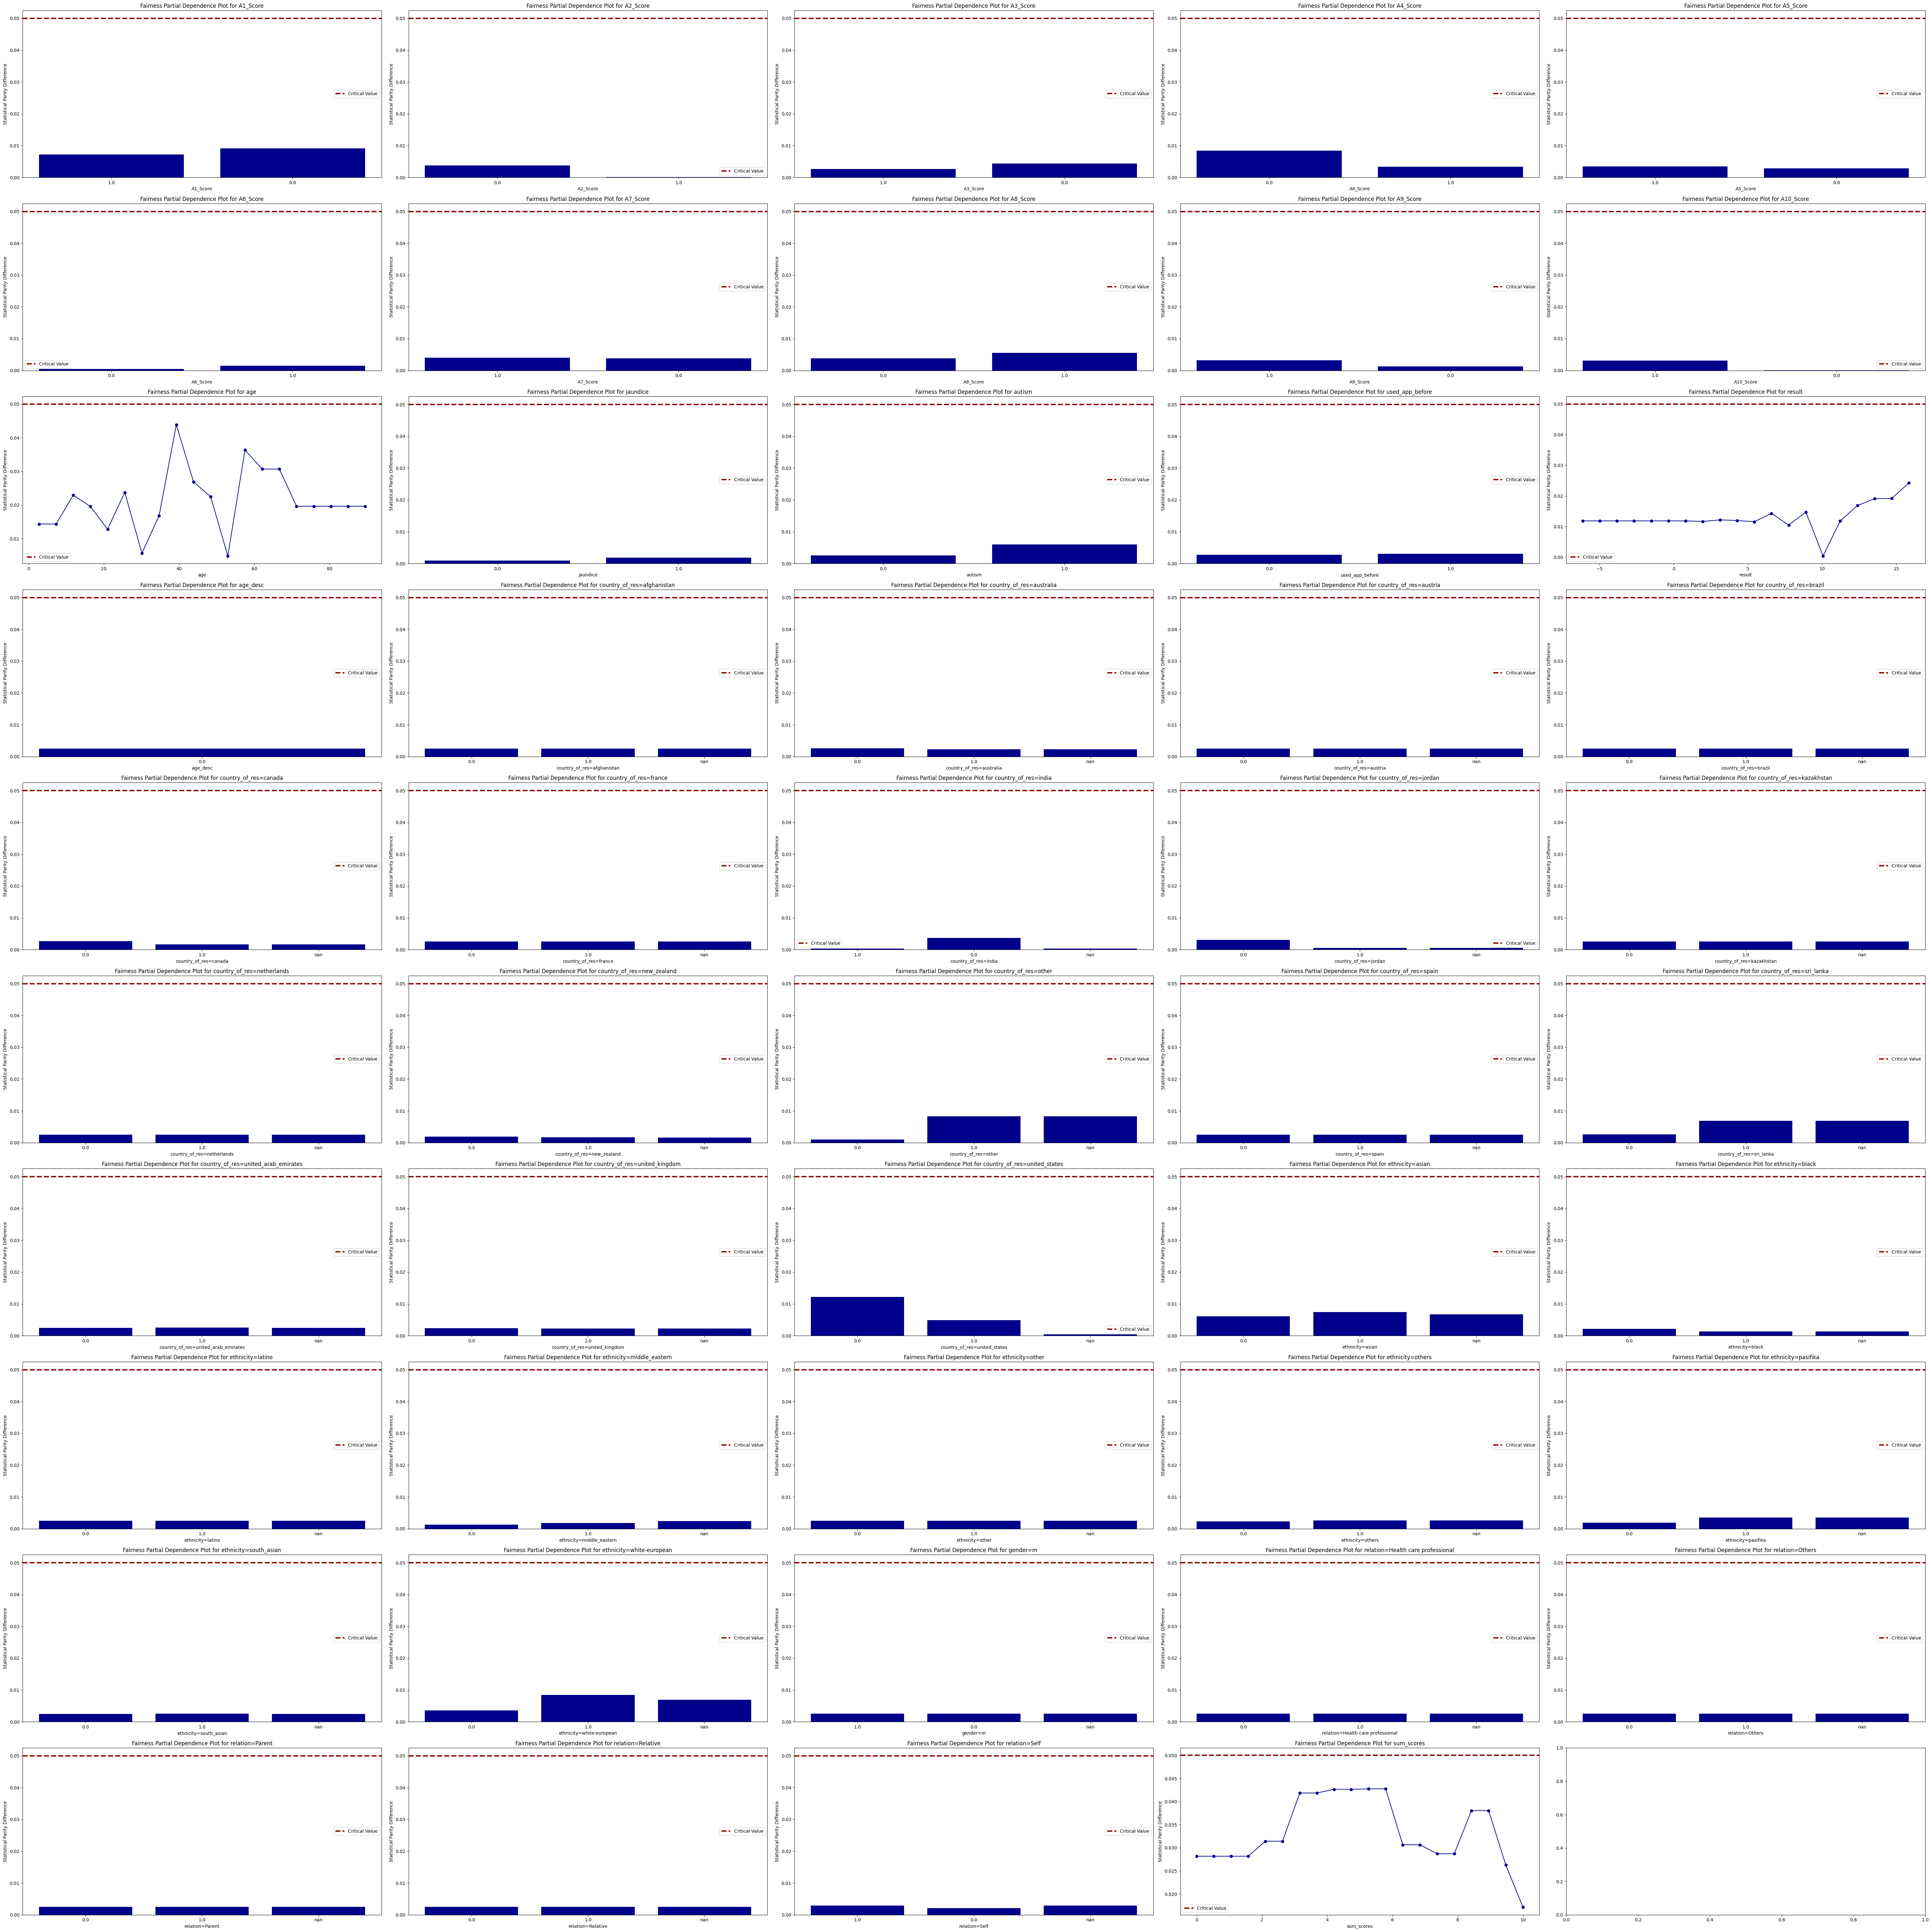

In [32]:
plot_fpdp_for_all_features_subplot(xgb_model, X, 'gender=f', protected_value=0, critical_value=0.05)